# Librerías

In [3]:
!pip install optuna
!pip install shap
!pip install seaborn
!pip install geopy

In [114]:
# Importamos librerías a utilizar
import pandas as pd
import numpy as np
import re
import optuna
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier
from scipy.stats import loguniform
from pycaret.classification import setup, compare_models, predict_model, save_model
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from imblearn.combine import SMOTEENN, SMOTETomek
from pandas import DataFrame
from imblearn.over_sampling import SMOTE

# Carga y visualización del dataset

El dataset se llama weatherAUS.csv y contiene información climática de Australia de los
últimos diez años, incluyendo si para el día siguiente llovió o no en la columna
‘RainTomorrow’. El objetivo del trabajo práctico es armar un ejecutable de Docker para
predecir, a las 23:59:59hs de cada día, si el día siguiente va a llover o no. Tiene alrededor de 145.460 y 23 columnas.

In [26]:
file_path= 'weatherAUS.csv'

df = pd.read_csv(file_path)

In [27]:
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [29]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

# 1. Clusters por región

In [30]:
ciudades = df["Location"].unique()
print(ciudades)

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']


Se precisa transformar algunos nombres de ciudades para poder generar los clusters correspondientes a las distintas regiones.

In [31]:
def formatear_ciudad(ciudad_sin_formato: str):
    """Función para formatear la ciudad"""
    ciudad = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', ciudad_sin_formato) + ", Australia"
    return ciudad

In [32]:
geolocator = Nominatim(user_agent="weatherAUS") # Instanciamos el geolocalizador
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1, max_retries=3, error_wait_seconds=2.0)
coord = []
for c in ciudades:
    c_form = formatear_ciudad(c)
    try:
        localizacion = geocode(c_form, timeout=10)
        if localizacion:
            coord.append((c, localizacion.latitude, localizacion.longitude))
        else:
            print(f"No se encontró {c}")
    except Exception as e:
        print(f"Error con: {c} - {e}")

df_coord = pd.DataFrame(coord, columns=["Location","Latitude","Longitude"])

## Método del codo

Para agrupar las ciudades en regiones se utilizará el algoritmo K-means, donde se usará el método del codo para calcular un valor adecuado de k.

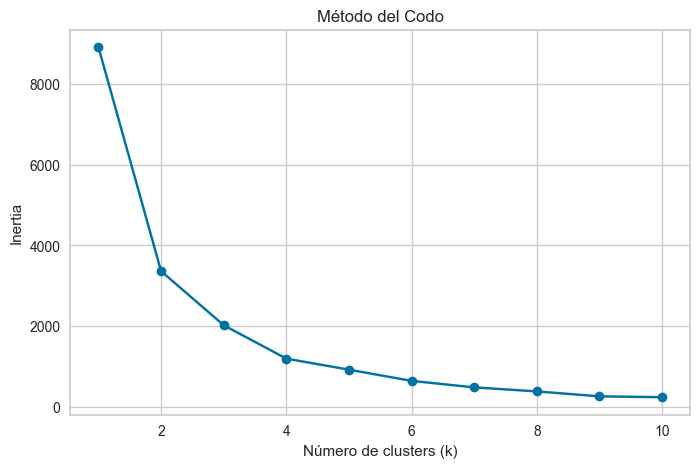

In [33]:
matriz_de_coordenadas = df_coord[['Latitude',  'Longitude']].values

inertias = []
K = range(1,11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(matriz_de_coordenadas)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inertia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

Del gráfico del método del codo se puede observar cómo a partir de 4 segmentos, la mejora que se produce en la
distancia interna de los segmentos ya es insignificante. Este hecho debería ser
indicativo de que 4 segmentos es un valor adecuado para k. Sin embargo, dado que este método puede ser ambiguo o poco fiable, se decidió buscar una validación adicional probando distintos valores para k.

## Implementación de K-means

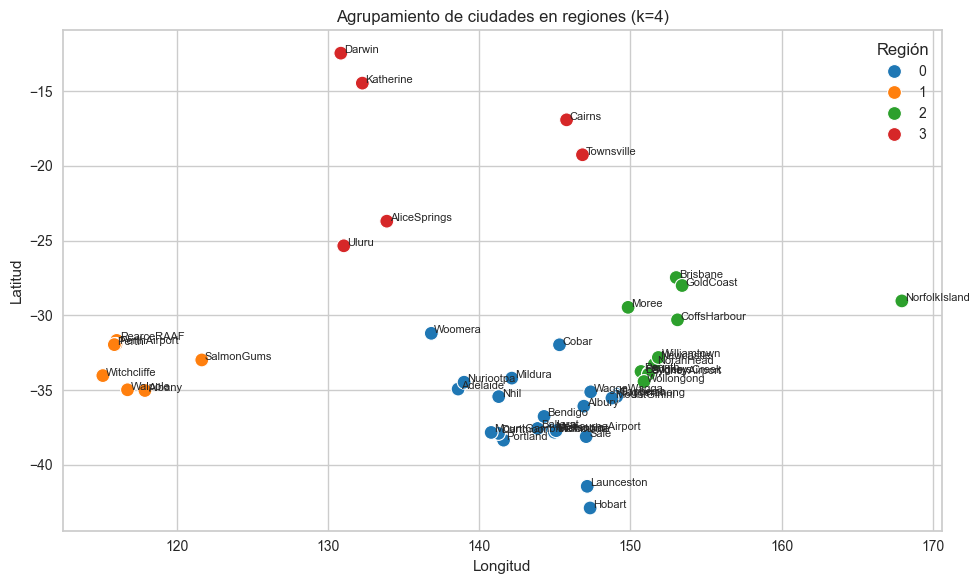

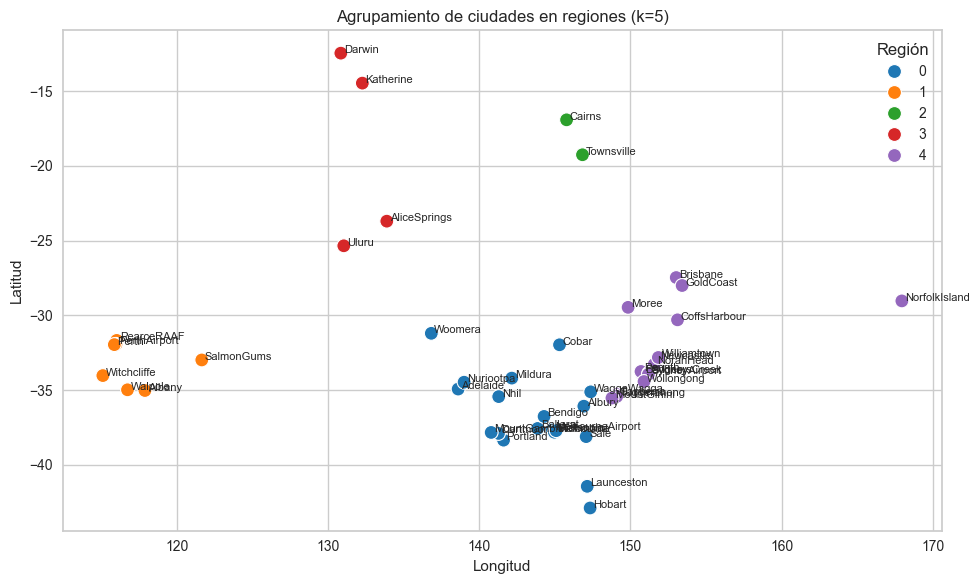

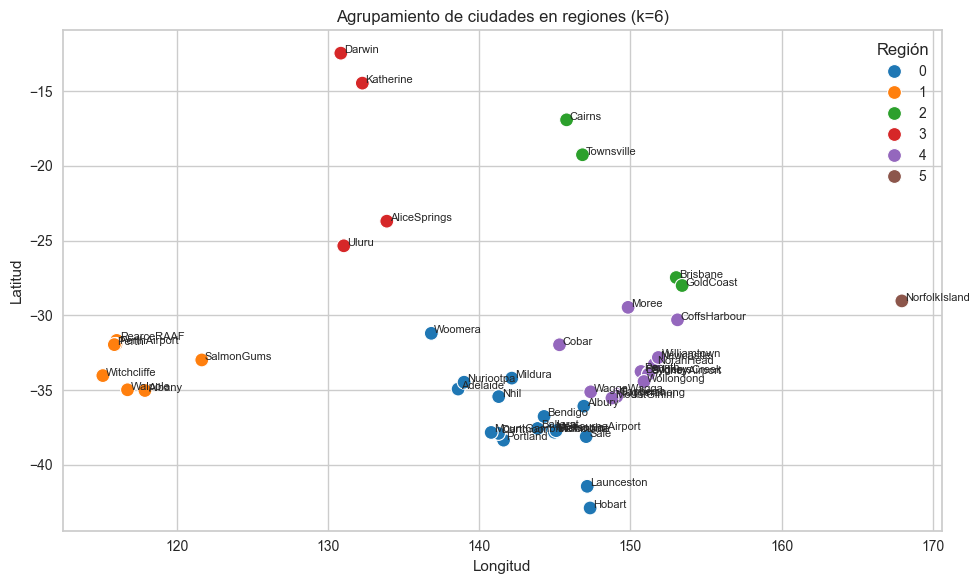

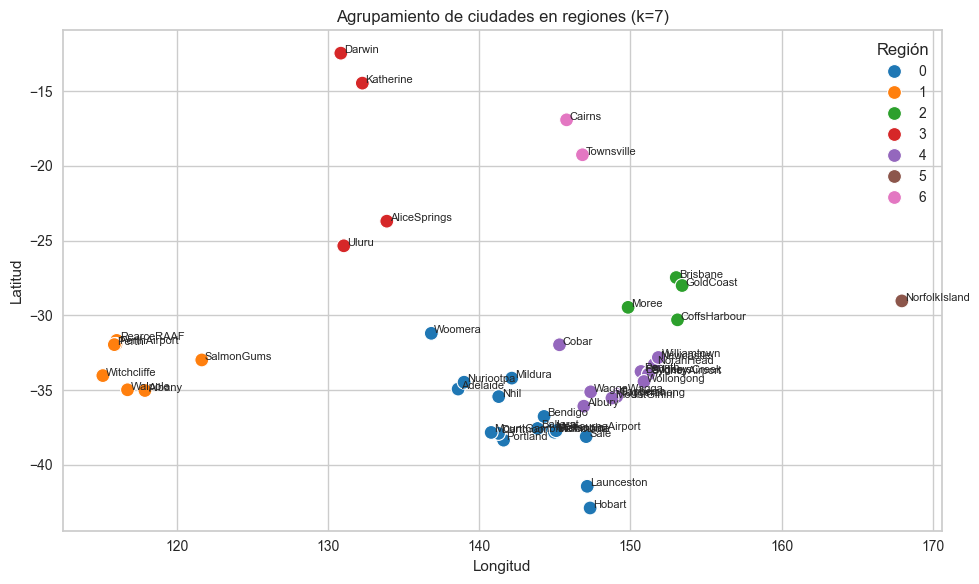

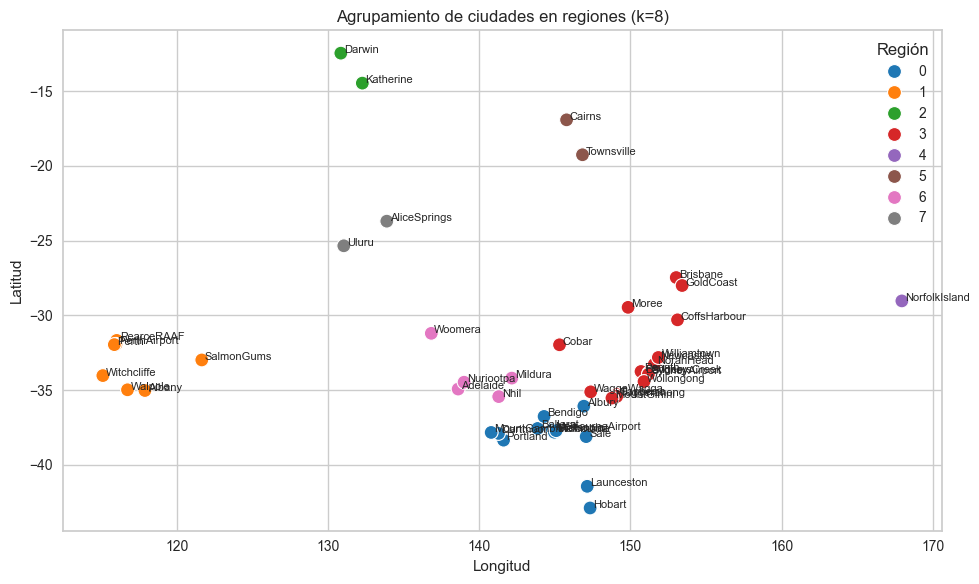

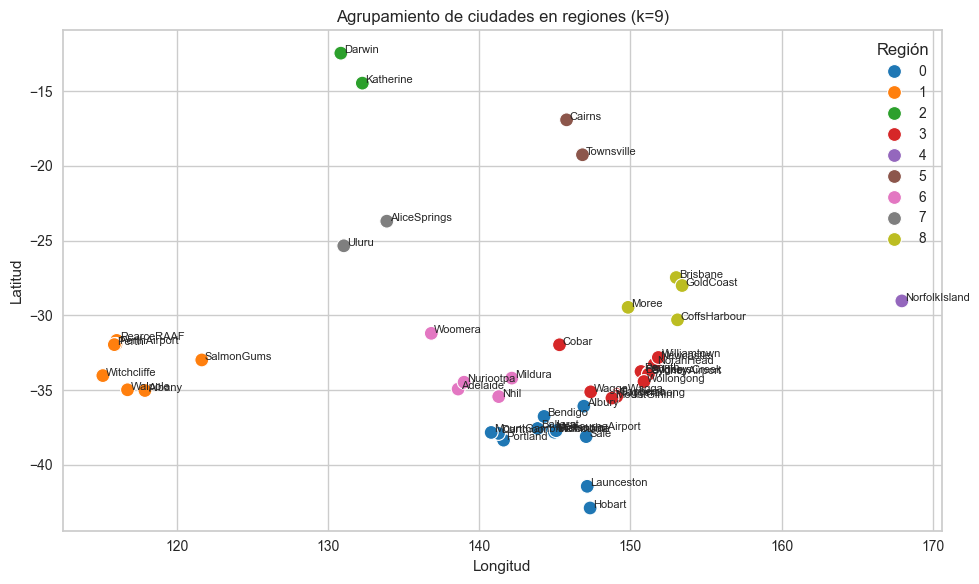

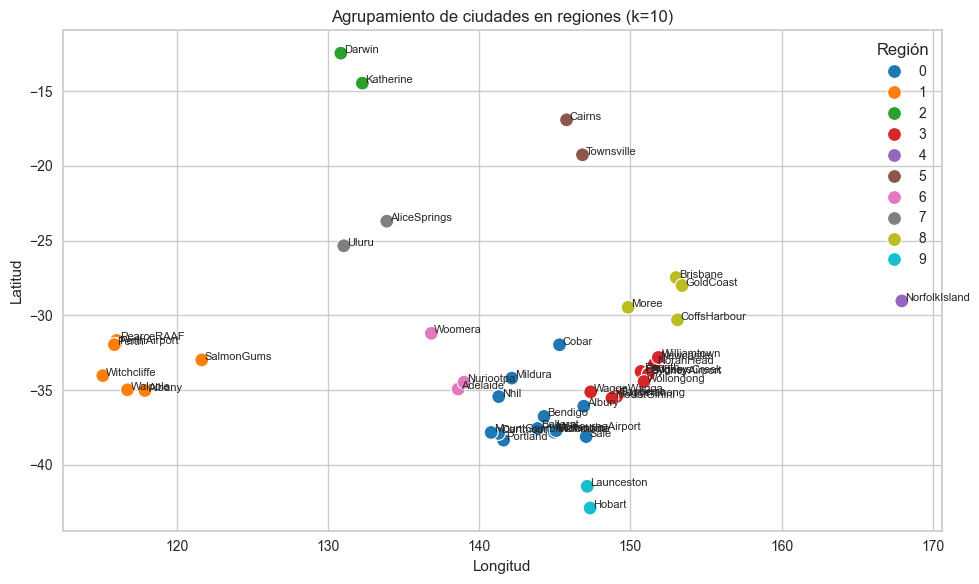

In [34]:
k_prob = [4, 5, 6, 7, 8, 9, 10]

df_coords_by_k = {}

for k in k_prob:
    df_coord_k = df_coord.copy()

    kmeans = KMeans(n_clusters=k, random_state=42)
    df_coord_k['Region'] = kmeans.fit_predict(df_coord_k[['Latitude', 'Longitude']].values)

    df_coords_by_k[k] = df_coord_k

    # plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_coord_k,
        x='Longitude', y='Latitude',
        hue='Region',
        palette='tab10',
        s=100
    )

    for _, row in df_coord_k.iterrows():
        plt.text(row['Longitude'] + 0.2, row['Latitude'], row['Location'], fontsize=8)

    plt.title(f'Agrupamiento de ciudades en regiones (k={k})')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.legend(title='Región')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Se procedió a realizar una inspección visual de las agrupaciones de ciudades en un gráfico de latitud y longitud, probando diferentes valores de k. Se buscó el valor de k que mejor alineara los clusters con las regiones geográficas y climáticas conocidas de Australia (https://www.researchgate.net/figure/Major-seasonal-rainfall-zones-of-Australia-source-Bureau-of-Meteorology-National_fig3_228535345). Se decidió elegir k=8.

# 2. Análisis descriptivo de datos

## Datos faltantes

In [35]:
def check_nan_percentage(df):
    nan_cant = df.isna().sum()
    nan_porcentaje = (nan_cant / len(df)) * 100

    nan_info = pd.DataFrame({
        'Cantidad': nan_cant,
        'Porcentaje': nan_porcentaje
    })

    nan_info['Porcentaje'] = nan_info['Porcentaje'].apply(lambda x: f"{x:.2f}%")

    print(nan_info)

check_nan_percentage(df)

               Cantidad Porcentaje
Date                  0      0.00%
Location              0      0.00%
MinTemp            1485      1.02%
MaxTemp            1261      0.87%
Rainfall           3261      2.24%
Evaporation       62790     43.17%
Sunshine          69835     48.01%
WindGustDir       10326      7.10%
WindGustSpeed     10263      7.06%
WindDir9am        10566      7.26%
WindDir3pm         4228      2.91%
WindSpeed9am       1767      1.21%
WindSpeed3pm       3062      2.11%
Humidity9am        2654      1.82%
Humidity3pm        4507      3.10%
Pressure9am       15065     10.36%
Pressure3pm       15028     10.33%
Cloud9am          55888     38.42%
Cloud3pm          59358     40.81%
Temp9am            1767      1.21%
Temp3pm            3609      2.48%
RainToday          3261      2.24%
RainTomorrow       3267      2.25%


In [36]:
df = df.merge(df_coords_by_k[8][['Location', 'Region']], on="Location", how="left")
df = df.drop(columns=['Location'])

In [37]:
df['Date'] = pd.to_datetime(df['Date'])

def estacion(date):
    mes = date.month
    if mes in [12, 1, 2]:
        return 'Verano'
    elif mes in [3, 4, 5]:
        return 'Otoño'
    elif mes in [6, 7, 8]:
        return 'Invierno'
    else:
        return 'Primavera'

df['Season'] = df['Date'].apply(estacion)
df = df.drop(columns=['Date'])

Se eliminan valores nulos de la variable objetivo en el dataset.

In [38]:
df = df[df["RainTomorrow"].notna()]

Se eliminan las filas con más de la mitad de datos nulos.

In [39]:
df = df.dropna(thresh=df.shape[1] - (df.shape[1] // 2 + 1))

In [40]:
check_nan_percentage(df)

               Cantidad Porcentaje
MinTemp             373      0.26%
MaxTemp             221      0.16%
Rainfall           1281      0.90%
Evaporation       60515     42.67%
Sunshine          67479     47.58%
WindGustDir        9041      6.37%
WindGustSpeed      8981      6.33%
WindDir9am         9666      6.82%
WindDir3pm         3464      2.44%
WindSpeed9am       1051      0.74%
WindSpeed3pm       2325      1.64%
Humidity9am        1481      1.04%
Humidity3pm        3310      2.33%
Pressure9am       13689      9.65%
Pressure3pm       13662      9.63%
Cloud9am          53360     37.62%
Cloud3pm          56754     40.01%
Temp9am             617      0.44%
Temp3pm            2429      1.71%
RainToday          1281      0.90%
RainTomorrow          0      0.00%
Region                0      0.00%
Season                0      0.00%


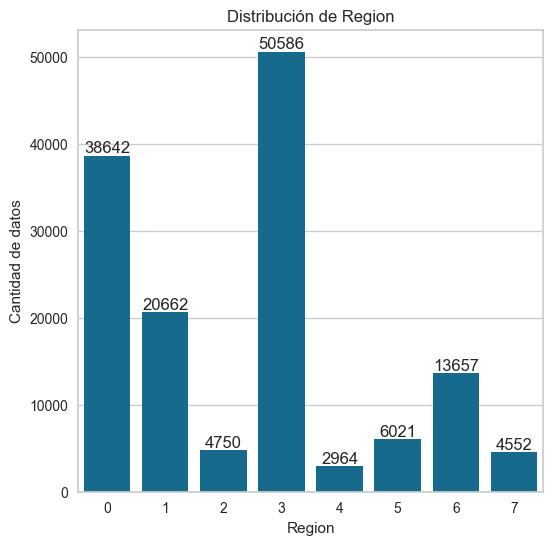

In [41]:
# Distribución de la variable Region
plt.figure(figsize=(6, 6))
ax = sns.countplot(x=df['Region'])

for container in ax.containers:
    ax.bar_label(container)

plt.title('Distribución de Region')
plt.xlabel('Region')
plt.ylabel('Cantidad de datos')
plt.show()

El gráfico revela una distribución desbalanceada de 'Region'. Las regiones 3 y 0 son las dominantes, concentrando la mayor cantidad de datos. En contraste, las regiones 2, 4 y 7 tienen una representación muy baja. Este desbalance refleja una distribución no uniforme de las observaciones climáticas en Australia, lo cual será considerado en las etapas de entrenamiento para evitar que el modelo tenga un bajo rendimiento o sesgo en la predicción de lluvia en las regiones menos representadas.

## Boxplots de cada variable

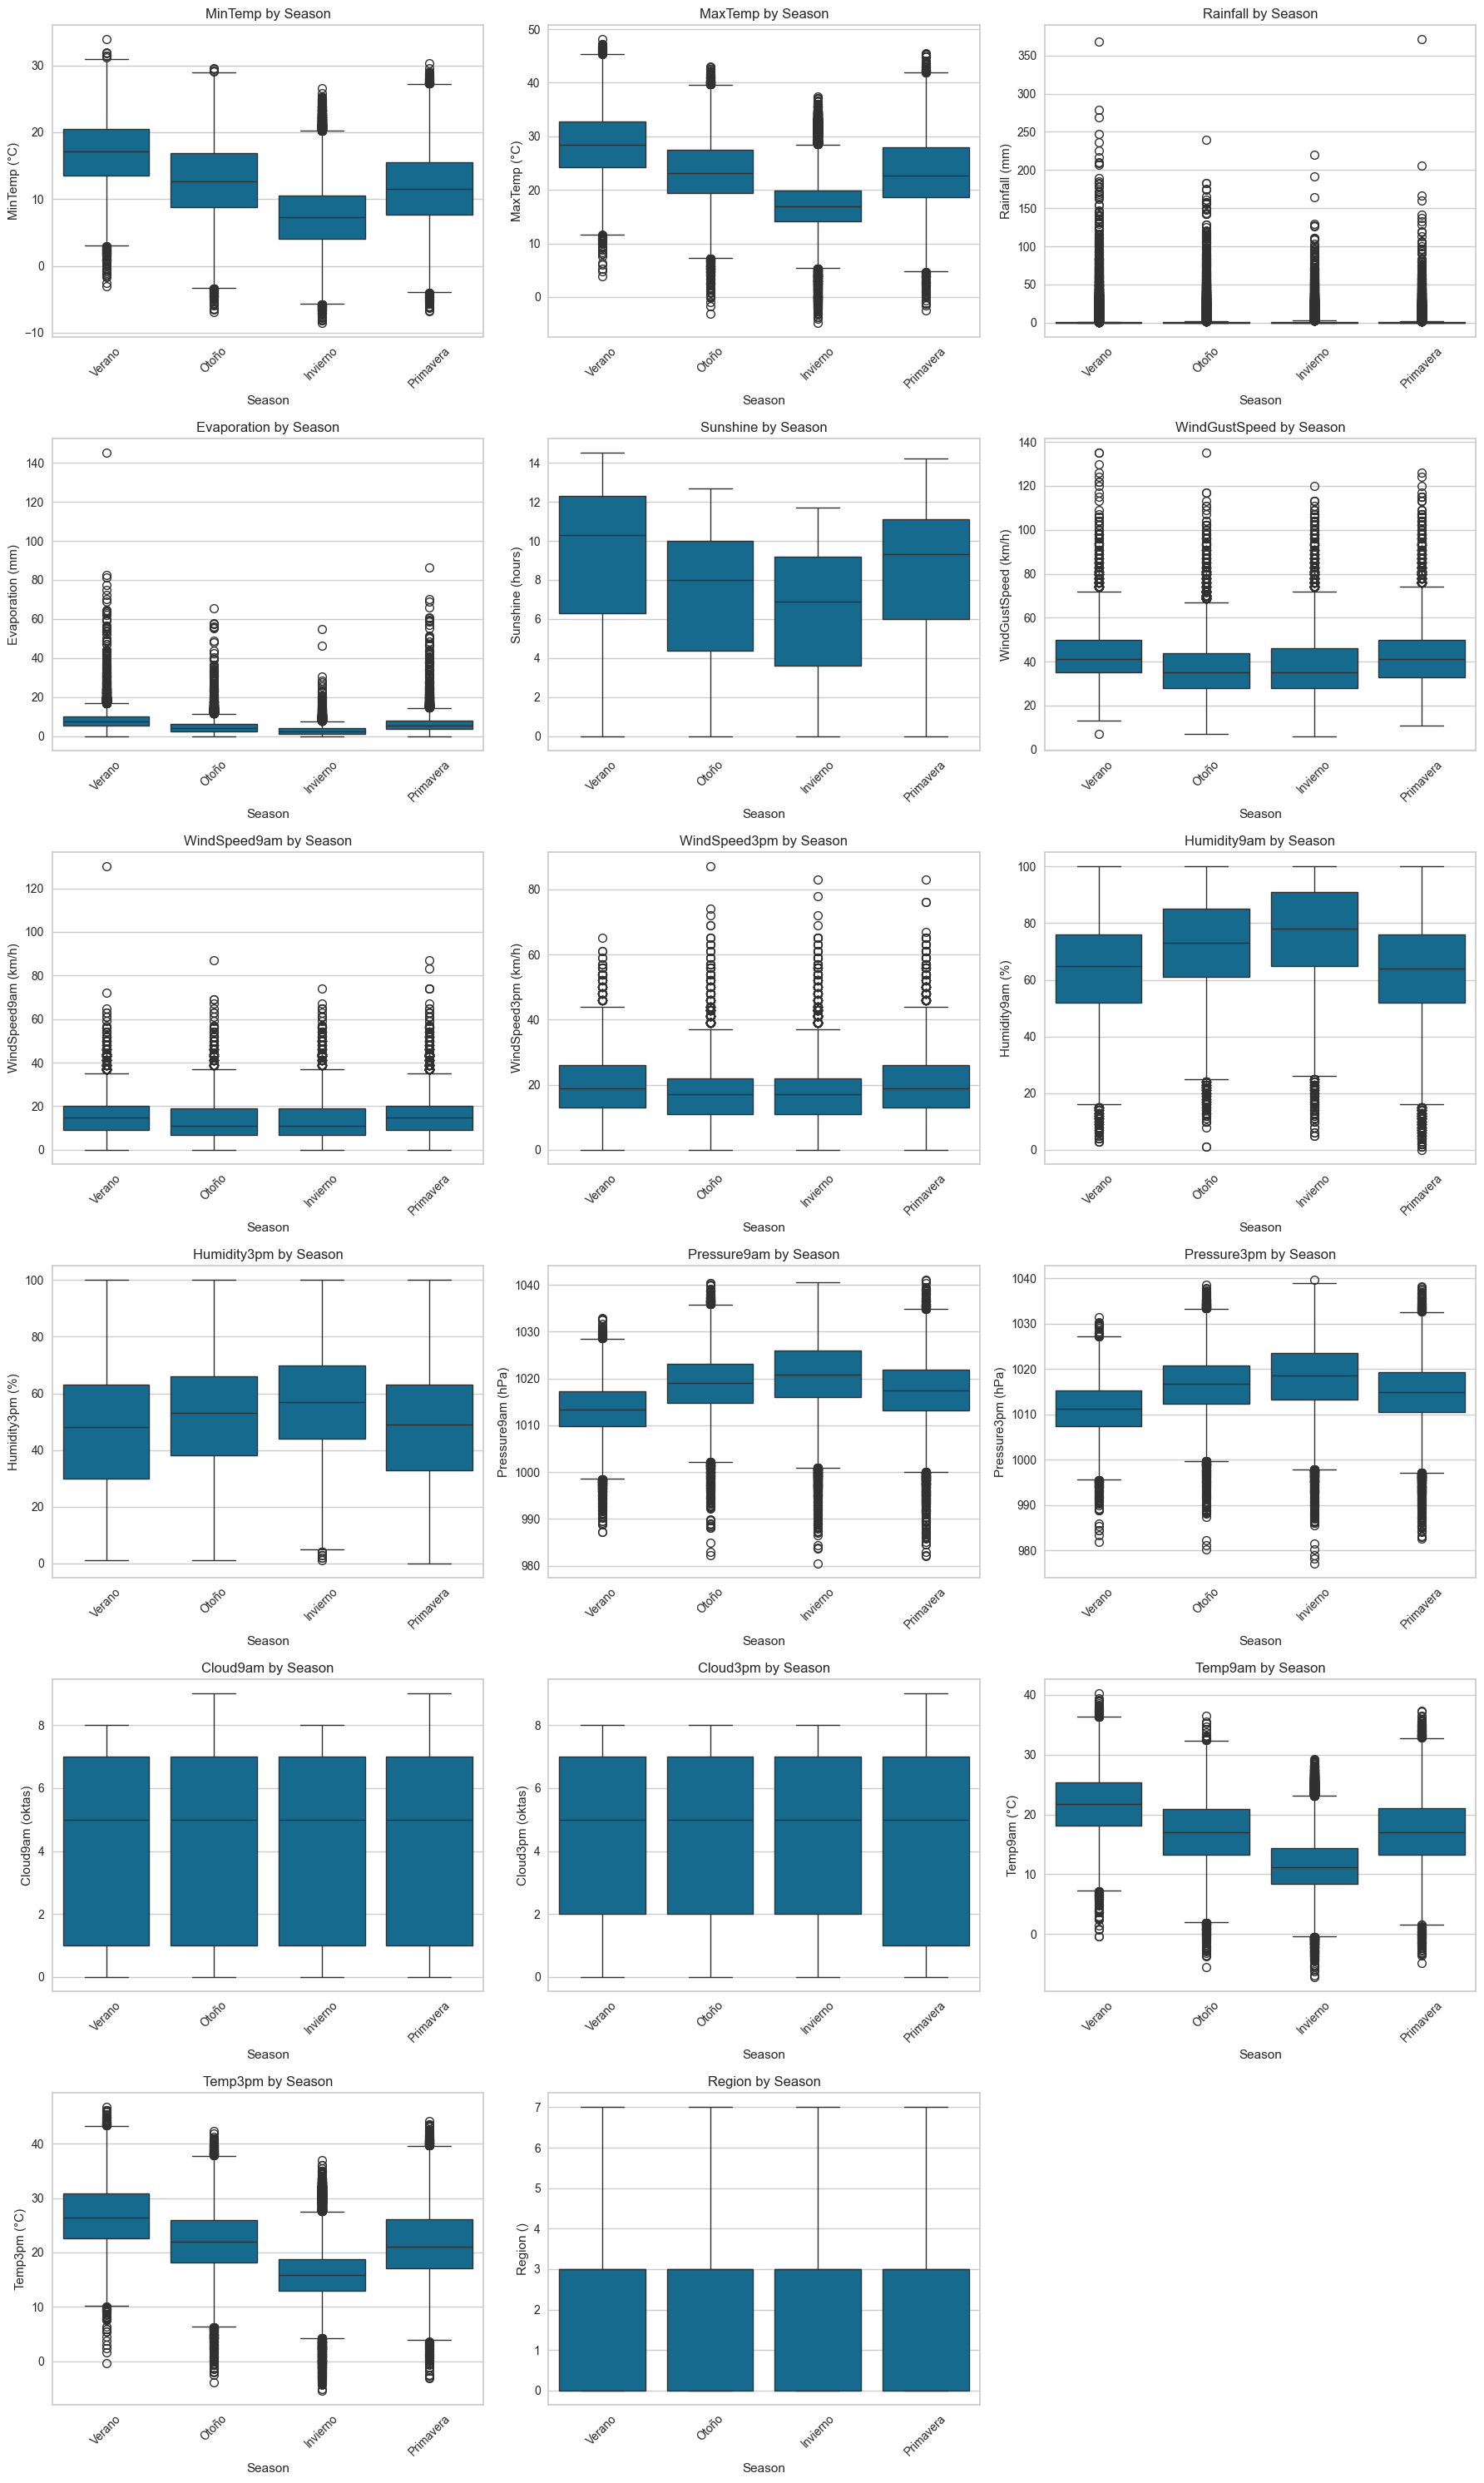

In [42]:
# Se seleccionan las columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Se agregan las unidades correspondientes
units = {
    'MinTemp': '°C',
    'MaxTemp': '°C',
    'Rainfall': 'mm',
    'Evaporation': 'mm',
    'Sunshine': 'hours',
    'WindGustSpeed': 'km/h',
    'WindSpeed9am': 'km/h',
    'WindSpeed3pm': 'km/h',
    'Humidity9am': '%',
    'Humidity3pm': '%',
    'Pressure9am': 'hPa',
    'Pressure3pm': 'hPa',
    'Cloud9am': 'oktas',
    'Cloud3pm': 'oktas',
    'Temp9am': '°C',
    'Temp3pm': '°C'
}

# Número de subplots y columnas
n_cols = len(numeric_cols)
n_rows = math.ceil(n_cols / 3)

# Subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5 * n_rows))
axes = axes.flatten()

# Boxplot para cada columna numérica
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x='Season', y=col, ax=axes[i])
    axes[i].set_title(f'{col} by Season')
    axes[i].set_xlabel('Season')
    axes[i].set_ylabel(f'{col} ({units.get(col, "")})')
    axes[i].tick_params(axis='x', rotation=45)

# Se ocultan subplots no útiles
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

A partir de la observación de los boxplots para cada variable y luego de investigar sobre su rango de variación y si los outliers mostrados son valores posibles en Australia, se considerarán todos los valores como posibles.

## Matriz de correlación general y por estación


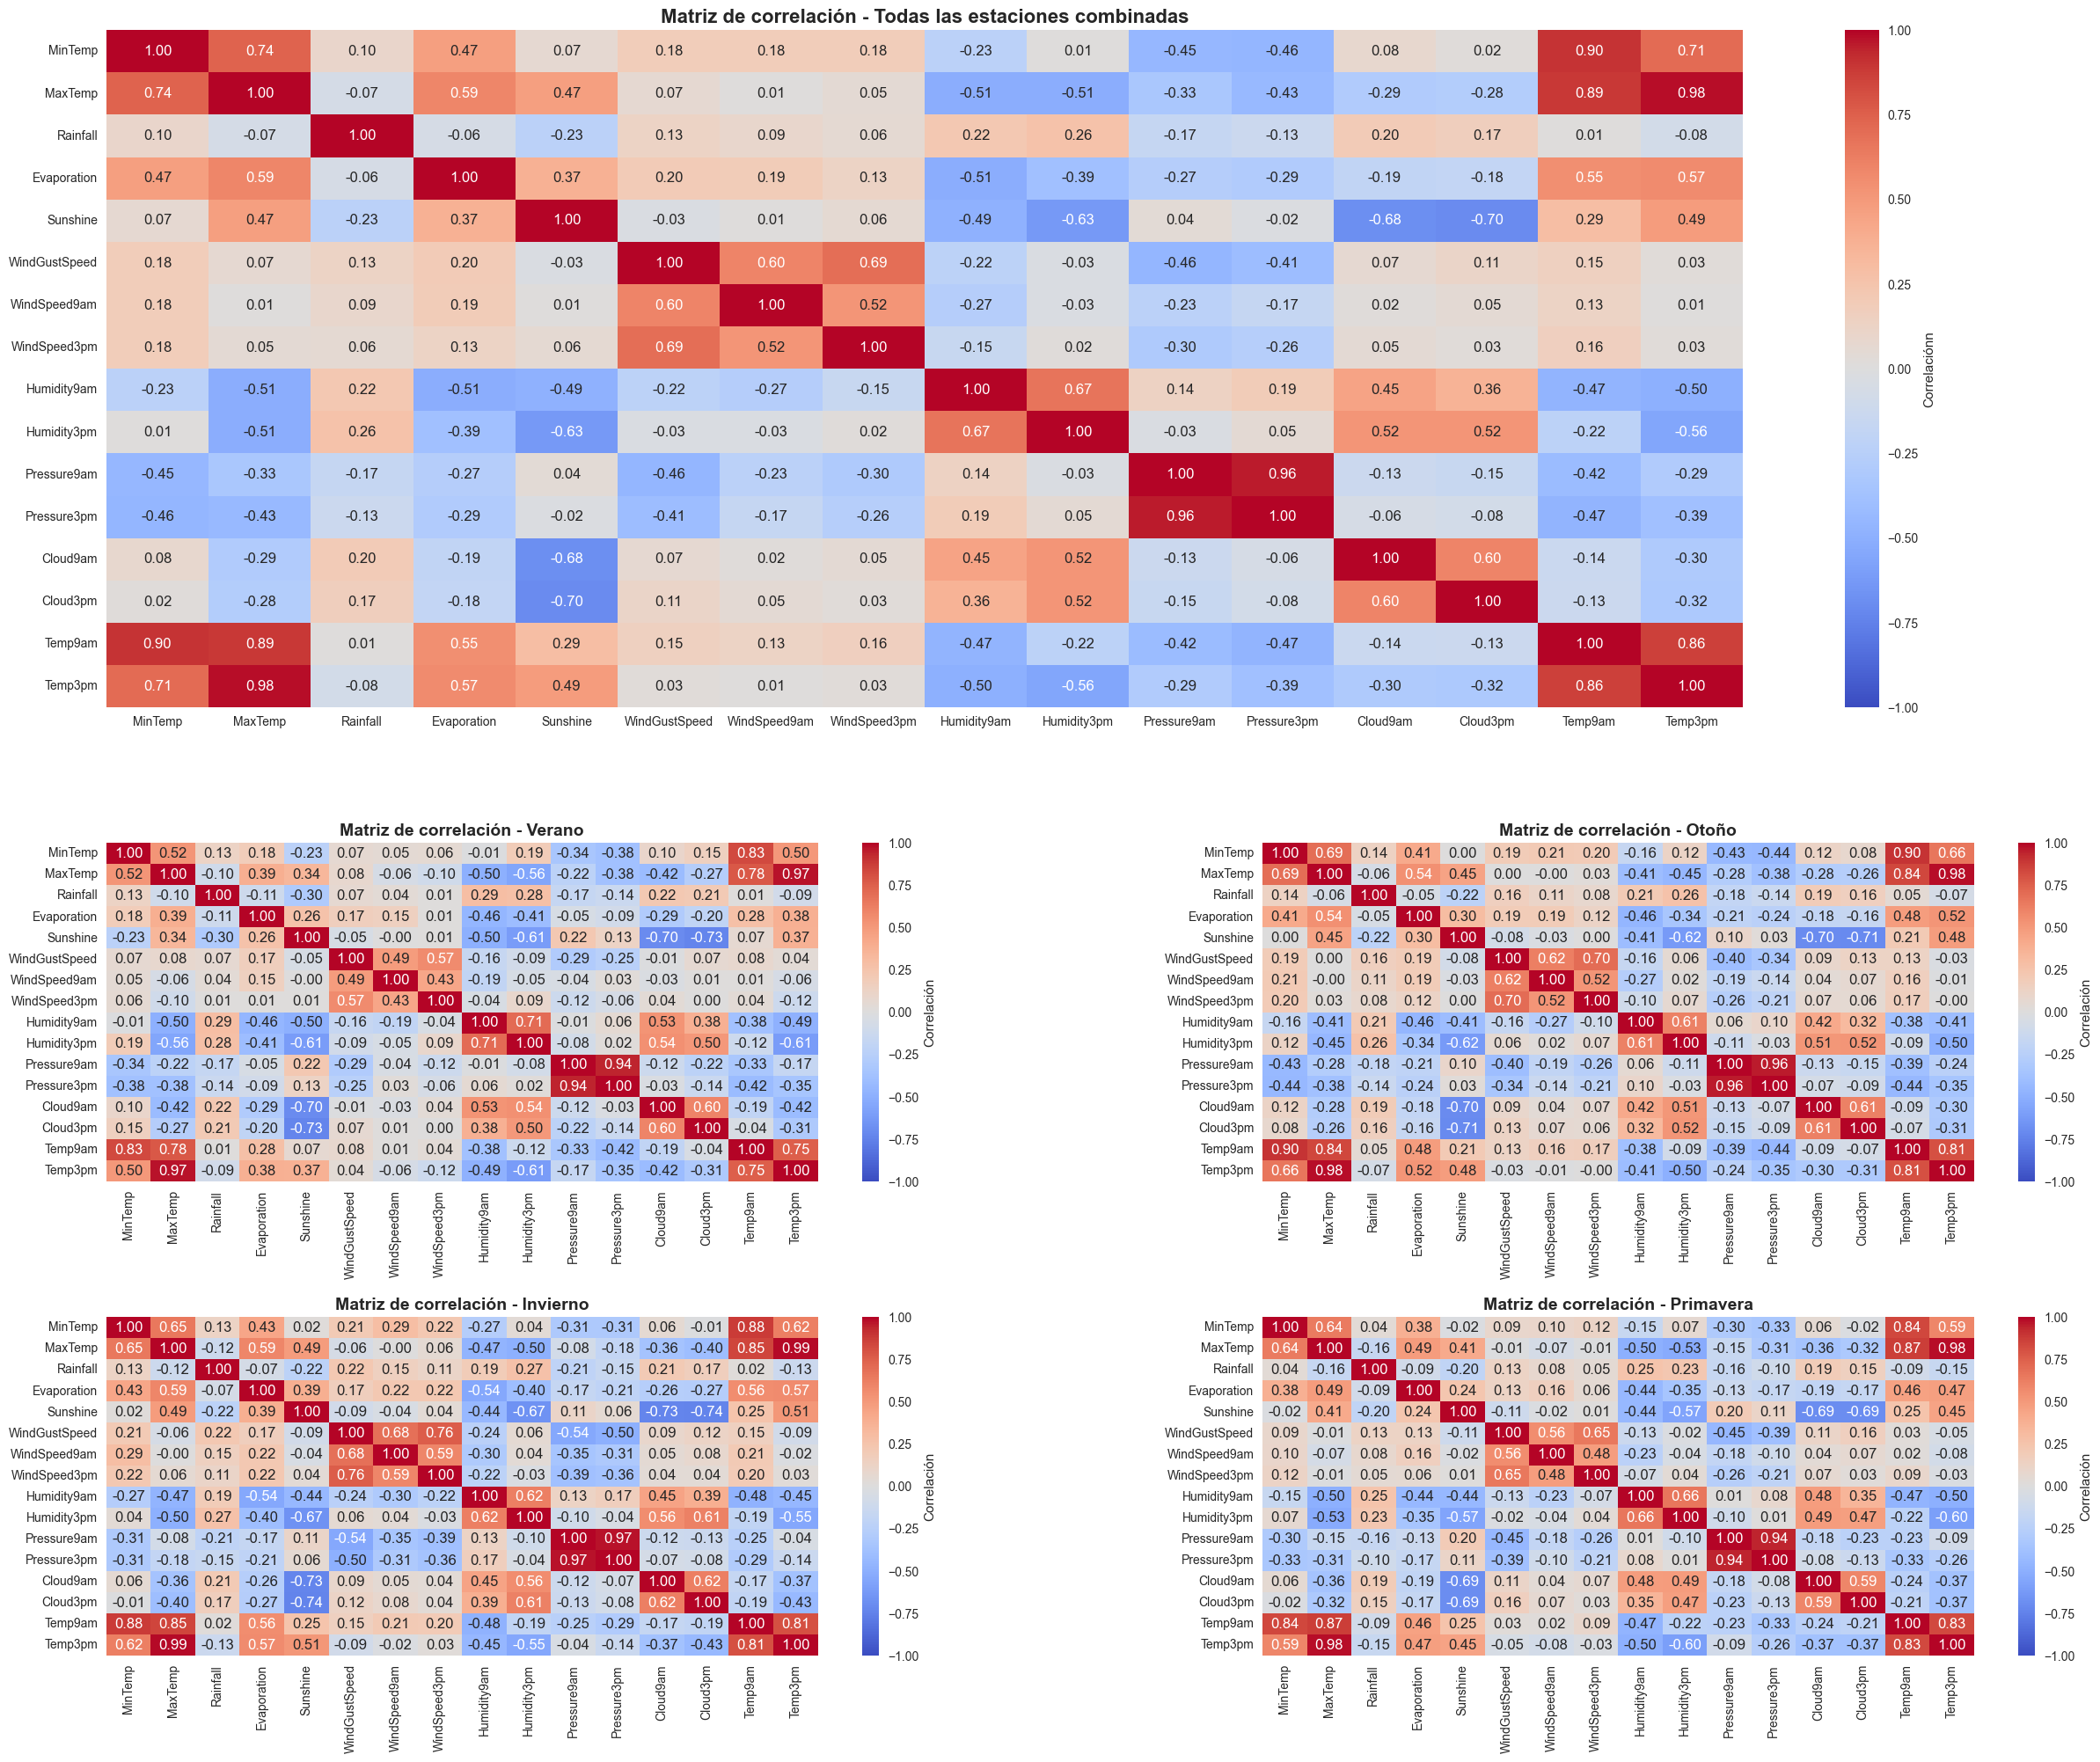

In [43]:
# Obtener columnas numéricas menos región
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Region' in numeric_cols:
    numeric_cols.remove('Region')

# Obtener estaciones únicas
seasons = df['Season'].unique()

# Crear GridSpec para custom layout
fig = plt.figure(figsize=(30, 24))
gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.3)

# Crear matrices de correlación (sin distinción de estaciones)
ax_overall = fig.add_subplot(gs[0, :])
df_overall = df[numeric_cols]
corr_overall = df_overall.corr().round(2)

sns.heatmap(corr_overall, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', ax=ax_overall, vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlaciónn'})

ax_overall.set_title('Matriz de correlación - Todas las estaciones combinadas', fontsize=16, fontweight='bold')

# Craer subplots para las matrices de correlación por estación
axes_seasons = []
for i in range(2):
    for j in range(2):
        axes_seasons.append(fig.add_subplot(gs[i+1, j]))

# Crear matrices de corrlación por estación
for i, season in enumerate(seasons):
    df_season = df[df['Season'] == season][numeric_cols]

    corr = df_season.corr().round(2)

    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0,
                fmt='.2f', ax=axes_seasons[i], vmin=-1, vmax=1,
                cbar_kws={'label': 'Correlación'})

    axes_seasons[i].set_title(f'Matriz de correlación - {season}', fontsize=14, fontweight='bold')

plt.show()

Sobre la matriz de correlación principal se pueden encontrar correlaciones positivas altas entre variables de temperatura y entre variables climáticas de las 9am y las 3pm. Además se observan algunas correlaciones negativas también altas entre humedad y temperatura, y entre humedad y horas en las que hay sol.

Respecto a las matrices pequeñas divididas por estación, se puede observar que las relaciones entre las variables no son constantes a lo largo del año. Mientras que las temperaturas se mantienen altas en todas las estaciones, las variables de humedad, lluvia o nubosidad cambian de una a otra. Por ejemplo, la correlación entre Rainfall y Cloud9am es mucho más fuerte en invierno que en verano, como pasa también en el caso de Humidity3pm y Rainfall.

## Distribución de la densidad por estación

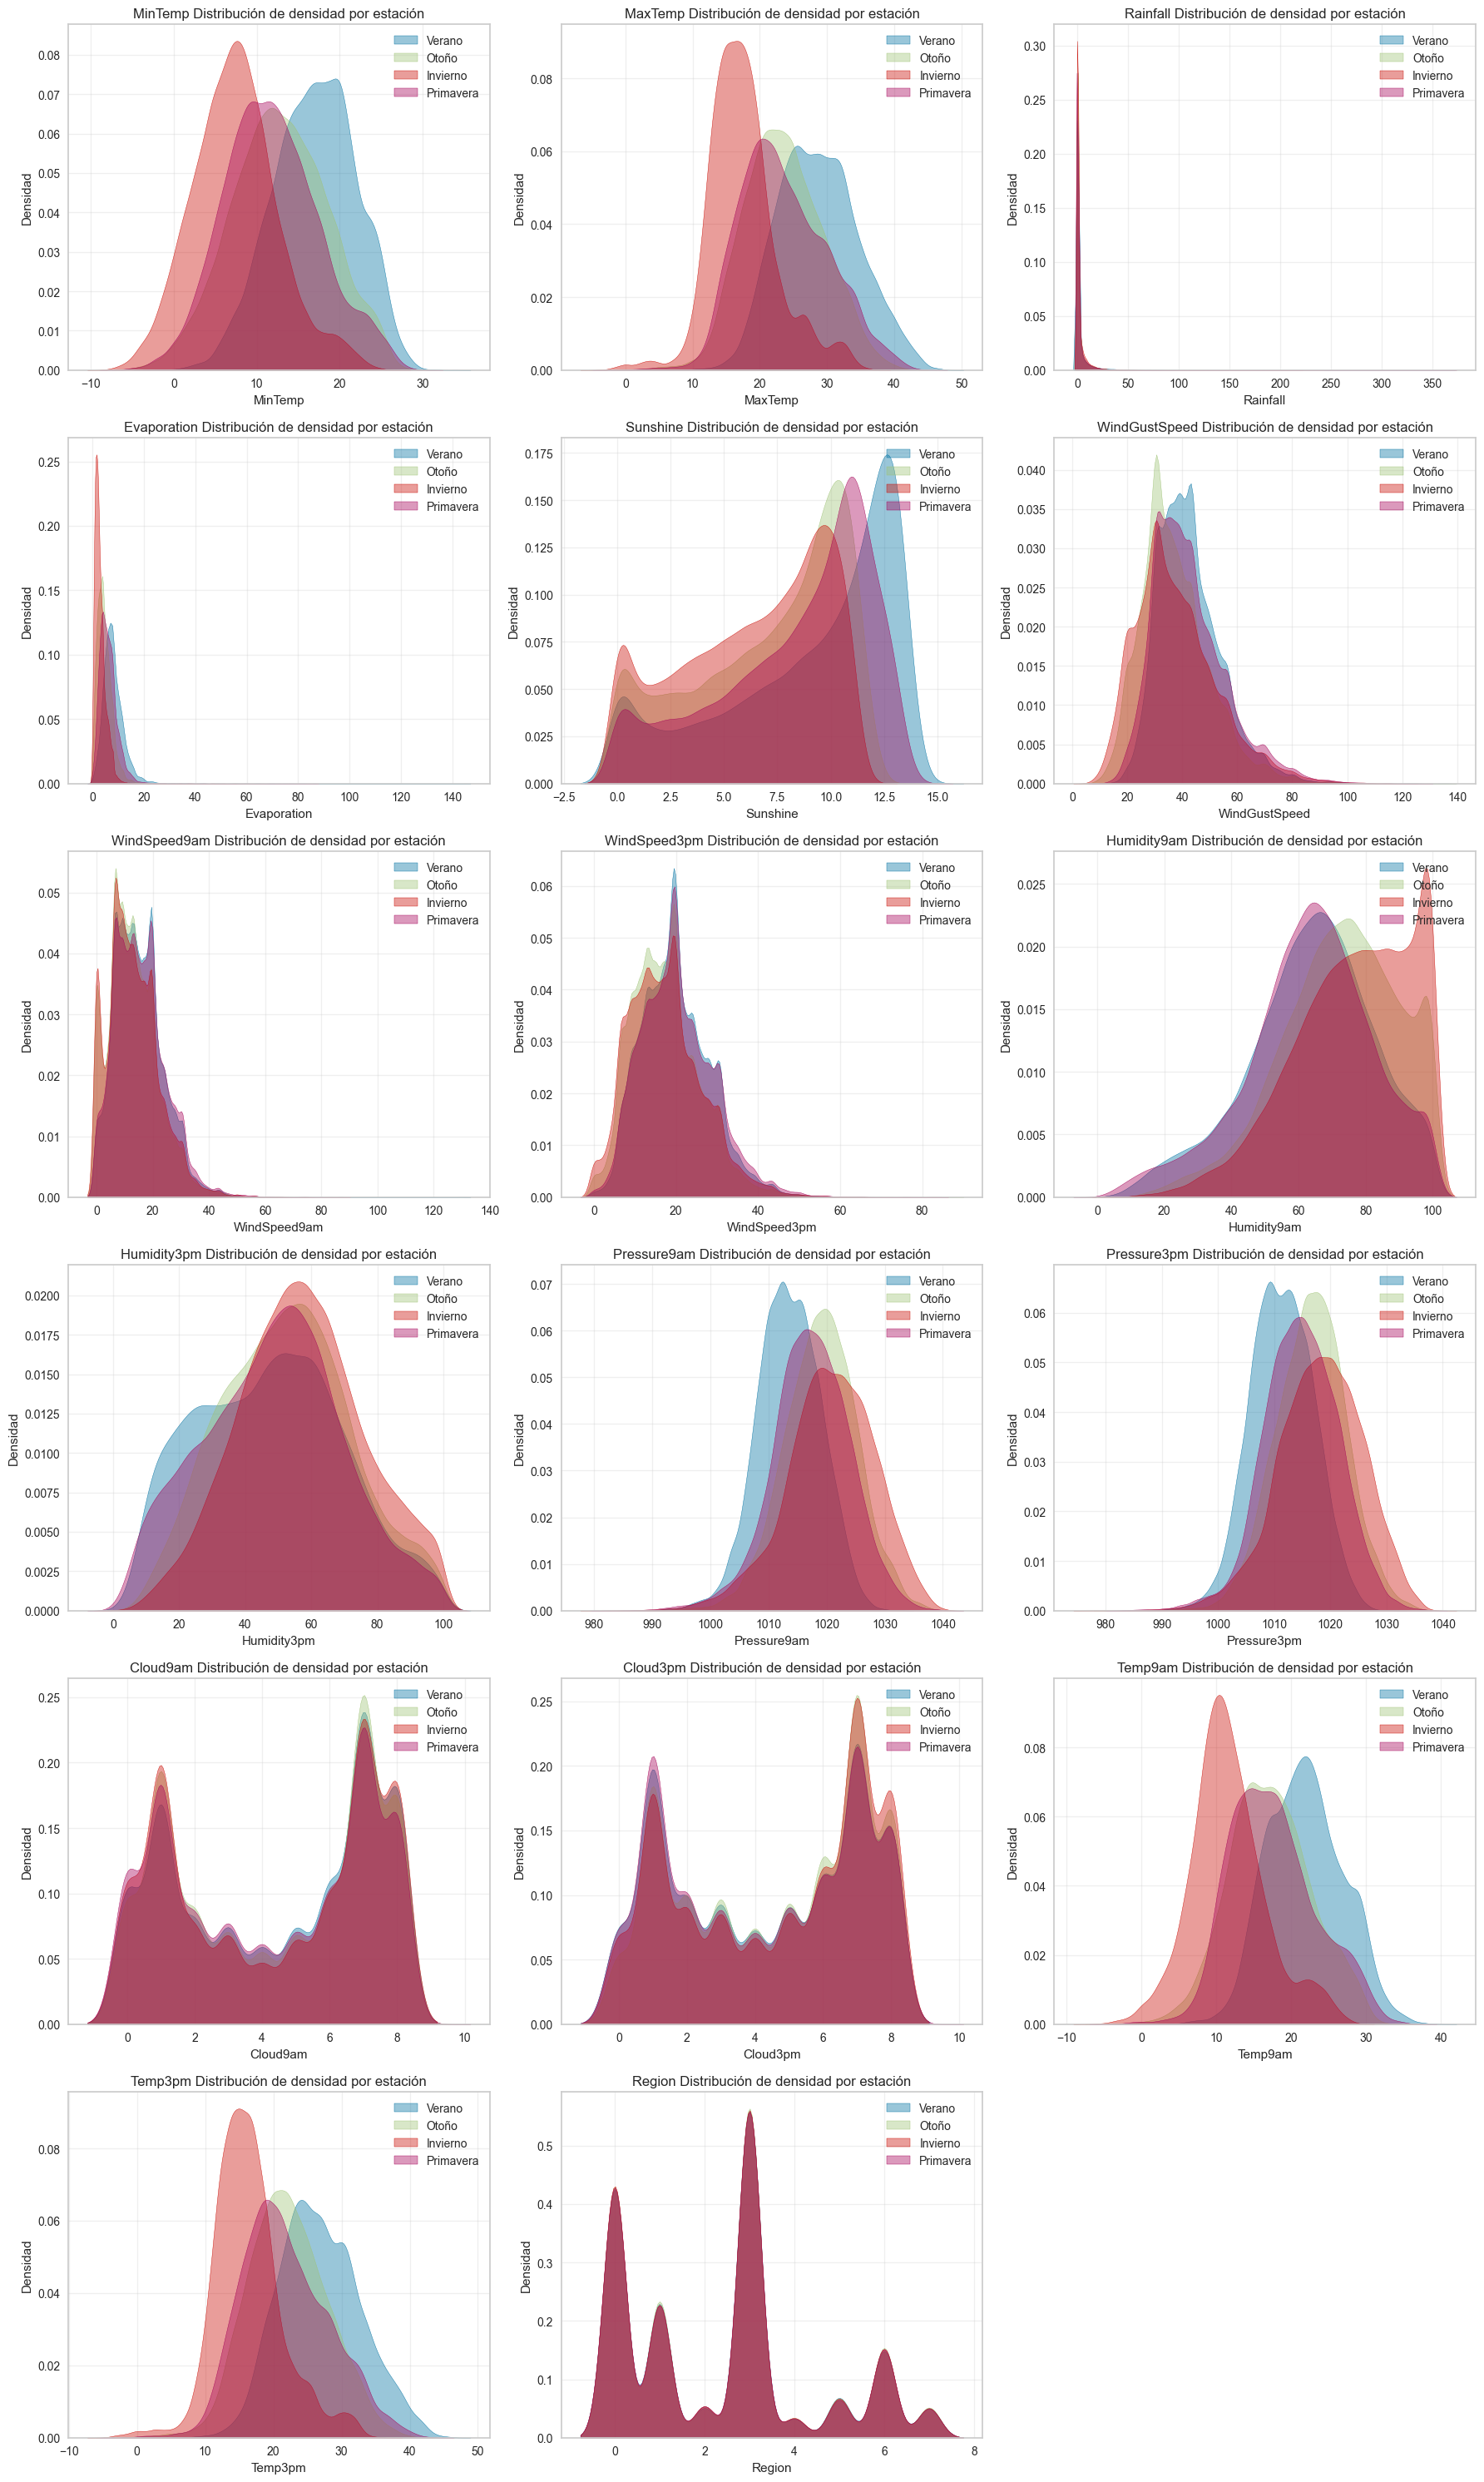

In [44]:
# Selecciona columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Número de subplots necesarios
n_cols = len(numeric_cols)
n_rows = math.ceil(n_cols / 3)

# Subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 5 * n_rows))
axes = axes.flatten()

# Distribución de densidad para cada variable numérica según estación
for i, col in enumerate(numeric_cols):
    for season in df['Season'].unique():
        data = df[df['Season'] == season][col].dropna() # Filter data by season and drop NaNs
        sns.kdeplot(data=data, ax=axes[i], label=season, fill=True, alpha=0.4)

    axes[i].set_title(f'{col} Distribución de densidad por estación')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Densidad')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Sobre las densidades se puede observar que:
- Temperatura (Temp3pm, Temp9am, MinTemp, MaxTemp): Las distribuciones están claramente separadas por estación, siendo verano la más cálida (desplazada a la derecha) e invierno la más fría (desplazada a la izquierda). Esto valida la importancia de la variable 'Season' para el modelo.

- Nubosidad (Cloud9am, Cloud3pm): La distribución es multimodal (con varios picos), especialmente notable en Cloud3pm, y muestra superposición entre las estaciones. Esto sugiere que la nubosidad es un feature complejo cuyas características no dependen únicamente de la estación.

- Lluvia (Rainfall): La distribución está sesgada a la derecha, con la gran mayoría de los valores concentrados en cero, lo cual es un indicador clave del desbalance de la variable objetivo ('RainTomorrow') y su dificultad predictiva.

- Presión (Pressure9am, Pressure3pm): Las distribuciones de presión son muy similares entre estaciones, mostrando una menor variabilidad estacional que las temperaturas, aunque la presión es ligeramente menor en verano.

## Distribucón de RainTomorrow

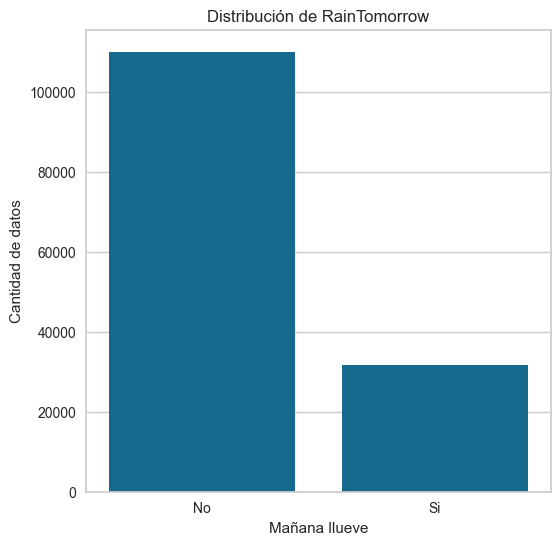

In [45]:
plt.figure(figsize=(6, 6))
sns.countplot(x=df['RainTomorrow'].map({'No': 'No', 'Yes': 'Si'}))
plt.title('Distribución de RainTomorrow')
plt.xlabel('Mañana llueve')
plt.ylabel('Cantidad de datos')
plt.show()

Este gráfico permite ver claramente que el dataset está claramente desbalanceado y que antes de implementar una solución se deberá utilizar algún método para balancearlo.

## Boxplots según RainTomorrow

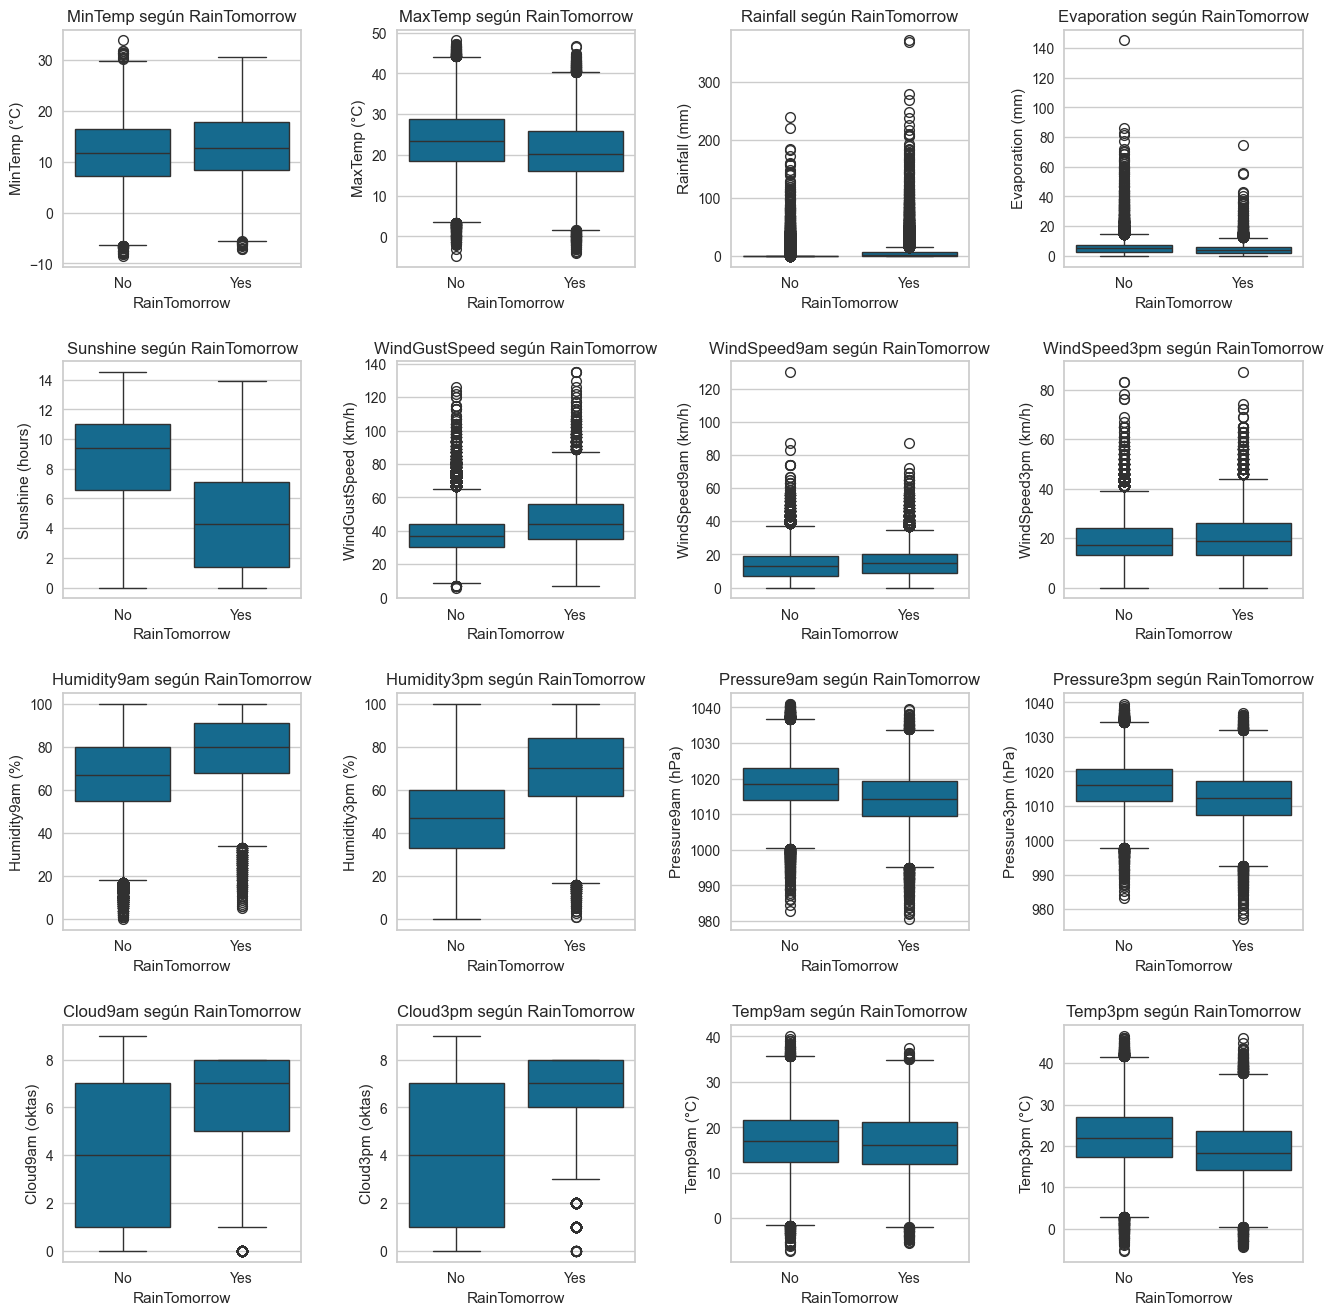

In [46]:
df_numerico = df.select_dtypes(include=['float64', 'int64'])
num_vars = len(df_numerico.columns)

# Unidades
units = {
    'MinTemp': '°C',
    'MaxTemp': '°C',
    'Rainfall': 'mm',
    'Evaporation': 'mm',
    'Sunshine': 'hours',
    'WindGustSpeed': 'km/h',
    'WindSpeed9am': 'km/h',
    'WindSpeed3pm': 'km/h',
    'Humidity9am': '%',
    'Humidity3pm': '%',
    'Pressure9am': 'hPa',
    'Pressure3pm': 'hPa',
    'Cloud9am': 'oktas',
    'Cloud3pm': 'oktas',
    'Temp9am': '°C',
    'Temp3pm': '°C',
    'Region': ''
}


fig, axes = plt.subplots(nrows=(num_vars // 4) + (num_vars % 4 > 0), ncols=4, figsize=(16, num_vars))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, column in enumerate(df_numerico):
    row, col_idx = divmod(i, 4)
    sns.boxplot(x='RainTomorrow', data=df, y=column, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{column} según RainTomorrow')
    axes[row, col_idx].set_xlabel('RainTomorrow')
    axes[row, col_idx].set_ylabel(f'{column} ({units.get(column, "")})')

for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()

Los gráficos de caja muestran que las variables clave para predecir la lluvia son aquellas con distribuciones visiblemente separadas entre los grupos 'No' y 'Yes'. Las features más distintivas son la Nubosidad (Cloud9am, Cloud3pm), la Humedad (Humidity9am, Humidity3pm), y las Horas de Sol (Sunshine). Por el contrario, las variables de Temperatura (MinTemp, MaxTemp, etc.) y Presión presentan distribuciones casi idénticas entre los dos grupos, indicando un bajo poder predictivo individual.

## Imputar valores faltantes

In [47]:
def imputar_por_region_y_estacion(df_train, df_test, cols_media, cols_mediana, cols_knn):
    df_train_imputed = df_train.copy()
    df_test_imputed = df_test.copy()

    # 1. Imputar por media: calcular estadísticas del train y aplicar a ambos
    for col in cols_media:
        # Calcular la media por Region y Season del df_train
        medias = df_train_imputed.groupby(['Region', 'Season'])[col].transform('mean')
        df_train_imputed[col] = df_train_imputed[col].fillna(medias)

        # Aplicar las mismas medias al df_test
        medias_dict = df_train.groupby(['Region', 'Season'])[col].mean().to_dict()
        df_test_imputed[col] = df_test_imputed.apply(
            lambda row: medias_dict.get((row['Region'], row['Season']), row[col])
            if pd.isna(row[col]) else row[col],
            axis=1
        )

    # 2. Imputar por mediana: calcular estadísticas del train y aplicar a ambos
    for col in cols_mediana:
        # Calcular la mediana por Region y Season del df_train
        medianas = df_train_imputed.groupby(['Region', 'Season'])[col].transform('median')
        df_train_imputed[col] = df_train_imputed[col].fillna(medianas)

        # Aplicar las mismas medianas al df_test
        medianas_dict = df_train.groupby(['Region', 'Season'])[col].median().to_dict()
        df_test_imputed[col] = df_test_imputed.apply(
            lambda row: medianas_dict.get((row['Region'], row['Season']), row[col])
            if pd.isna(row[col]) else row[col],
            axis=1
        )

    # 3. Imputar por KNN: entrenar con train, transformar ambos
    for (region, season), df_region_train in df_train_imputed.groupby(['Region', 'Season']):
        # Entrenar el imputador con los datos de train
        imputador = KNNImputer(n_neighbors=5)
        imputador.fit(df_region_train[cols_knn])

        # Transformar train
        imputadas_train = imputador.transform(df_region_train[cols_knn])
        df_train_imputed.loc[df_region_train.index, cols_knn] = imputadas_train

        # Transformar test (si existen datos para esta combinación de Region y Season)
        df_region_test = df_test_imputed[
            (df_test_imputed['Region'] == region) &
            (df_test_imputed['Season'] == season)
        ]
        if len(df_region_test) > 0:
            imputadas_test = imputador.transform(df_region_test[cols_knn])
            df_test_imputed.loc[df_region_test.index, cols_knn] = imputadas_test

    return df_train_imputed, df_test_imputed

def imputar_categoricas_por_moda(df_train, df_test, cols_categoricas):
    """
    Imputa variables categóricas usando la moda por Region y Season.
    Aprende las modas del df_train y las aplica a ambos dataframes.

    Args:
        df_train: DataFrame de entrenamiento
        df_test: DataFrame de prueba
        cols_categoricas: Lista de columnas categóricas a imputar

    Returns:
        Tupla (df_train_imputed, df_test_imputed)
    """
    df_train_imputed = df_train.copy()
    df_test_imputed = df_test.copy()

    for col in cols_categoricas:
        # Calcular la moda por Region y Season del df_train
        # lambda x: x.mode()[0] if not x.mode().empty else None maneja casos sin moda
        modas_dict = df_train.groupby(['Region', 'Season'])[col].apply(
            lambda x: x.mode()[0] if not x.mode().empty else None
        ).to_dict()

        # Aplicar la moda al df_train
        df_train_imputed[col] = df_train_imputed.apply(
            lambda row: modas_dict.get((row['Region'], row['Season']), row[col])
            if pd.isna(row[col]) else row[col],
            axis=1
        )

        # Aplicar las mismas modas al df_test
        df_test_imputed[col] = df_test_imputed.apply(
            lambda row: modas_dict.get((row['Region'], row['Season']), row[col])
            if pd.isna(row[col]) else row[col],
            axis=1
        )

    return df_train_imputed, df_test_imputed

La imputación de valores faltantes se realizará con los siguientes criterior:
- Promedio ==> variables que tienen una distribución sesgada o con valores atípicos
- Media ==> distribución simétrica o normal
- KNN ==> distribuciones multimodales

In [48]:
cols_media = ['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
cols_mediana = ['WindSpeed9am', 'WindSpeed3pm', 'WindGustSpeed']
cols_knn = ['Evaporation','Rainfall', 'Cloud9am','Cloud3pm', 'Sunshine']
cols_cat = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

## Split en train-test

In [49]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
train_df, test_df = imputar_por_region_y_estacion(train_df, test_df, cols_media, cols_mediana, cols_knn)
train_df, test_df = imputar_categoricas_por_moda(train_df, test_df, cols_cat)

In [50]:
train_df.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
Region           0
Season           0
dtype: int64

## Codificación de variables categóricas

In [51]:
train_df['WindGustDir'].unique()

array(['NE', 'ESE', 'SE', 'ENE', 'S', 'NNW', 'SSW', 'N', 'E', 'W', 'NW',
       'WNW', 'WSW', 'SW', 'NNE', 'SSE'], dtype=object)

Se codifican la variables 'WindGustDir', 'WindDir9am', 'WindDir3pm' de manera cíclica utilizando seno y coseno, y las variables 'Region', 'Season', 'RainToday', 'RainTomorrow' con one-hot encoding.

In [52]:
def codificar_viento_ciclico(df_train, df_test, cols_viento):
    """
    Codifica direcciones de viento de forma cíclica usando seno y coseno.

    Args:
        df_train: DataFrame de entrenamiento
        df_test: DataFrame de prueba
        cols_viento: Lista de columnas de dirección de viento a codificar

    Returns:
        Tupla (df_train_encoded, df_test_encoded)
    """
    # Orden de las direcciones de viento (16 puntos cardinales)
    direcciones = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
                    'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']

    # Crear un mapeo de dirección a ángulo (en radianes)
    # Cada dirección está separada por 360/16 = 22.5 grados
    angulos = {direccion: (i * 2 * np.pi / 16) for i, direccion in enumerate(direcciones)}

    df_train_encoded = df_train.copy()
    df_test_encoded = df_test.copy()

    for col in cols_viento:
        # Mapear direcciones a ángulos y calcular seno y coseno
        train_angulos = df_train_encoded[col].map(angulos)
        test_angulos = df_test_encoded[col].map(angulos)

        # Crear columnas de seno y coseno
        df_train_encoded[f'{col}_sin'] = train_angulos.apply(lambda x: np.sin(x) if pd.notna(x) else np.nan)
        df_train_encoded[f'{col}_cos'] = train_angulos.apply(lambda x: np.cos(x) if pd.notna(x) else np.nan)

        df_test_encoded[f'{col}_sin'] = test_angulos.apply(lambda x: np.sin(x) if pd.notna(x) else np.nan)
        df_test_encoded[f'{col}_cos'] = test_angulos.apply(lambda x: np.cos(x) if pd.notna(x) else np.nan)

        # Eliminar la columna original
        df_train_encoded = df_train_encoded.drop(columns=[col])
        df_test_encoded = df_test_encoded.drop(columns=[col])

    return df_train_encoded, df_test_encoded


def codificar_dummies(df_train, df_test, cols_dummies):
    """
    Codifica variables categóricas usando one-hot encoding (variables dummy).

    Args:
        df_train: DataFrame de entrenamiento
        df_test: DataFrame de prueba
        cols_dummies: Lista de columnas a codificar con dummies

    Returns:
        Tupla (df_train_encoded, df_test_encoded)
    """
    # Aplicar get_dummies a train
    df_train_encoded = pd.get_dummies(df_train, columns=cols_dummies, drop_first=True)

    # Aplicar get_dummies a test
    df_test_encoded = pd.get_dummies(df_test, columns=cols_dummies, drop_first=True)

    # Asegurar que test tenga las mismas columnas que train (en el mismo orden)
    # Agregar columnas faltantes en test con valores 0
    for col in df_train_encoded.columns:
        if col not in df_test_encoded.columns:
            df_test_encoded[col] = 0

    # Reordenar las columnas de test para que coincidan con train
    df_test_encoded = df_test_encoded[df_train_encoded.columns]

    return df_train_encoded, df_test_encoded

In [53]:
cols_viento = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
train_df, test_df = codificar_viento_ciclico(train_df, test_df, cols_viento)

cols_dummies = ['Region', 'Season', 'RainToday', 'RainTomorrow']
train_df, test_df = codificar_dummies(train_df, test_df, cols_dummies)

In [54]:
# Todas las columnas que NO son dummies
cols_dummies = [col for col in train_df.columns if any(x in col for x in ['Region_', 'Season_', 'RainToday_'])]
# Excluir RainTomorrow_Yes del escalado (es la variable objetivo y debe mantenerse binaria)
cols_a_estandarizar = [col for col in train_df.columns
                       if col not in cols_dummies and col != 'RainTomorrow_Yes']

scaler = StandardScaler()
train_df[cols_a_estandarizar] = scaler.fit_transform(train_df[cols_a_estandarizar])
test_df[cols_a_estandarizar] = scaler.transform(test_df[cols_a_estandarizar])

In [55]:
train_df.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'WindGustDir_sin', 'WindGustDir_cos',
       'WindDir9am_sin', 'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos',
       'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6',
       'Region_7', 'Season_Otoño', 'Season_Primavera', 'Season_Verano',
       'RainToday_Yes', 'RainTomorrow_Yes'],
      dtype='object')

## Aplicación de SMOTE-ENN para balanceo de clases

### Comparación entre SMOTE-ENN y SMOTE-Tomek

#### Diferencias esperadas entre los métodos:

**SMOTE-ENN:**
- Más agresivo en la limpieza
- Elimina más muestras (especialmente de la clase mayoritaria)
- Dataset final generalmente más pequeño
- Mejor para eliminar ruido y muestras ambiguas

**SMOTE-Tomek:**
- Más conservador
- Solo elimina pares en la frontera entre clases (Tomek Links)
- Dataset final generalmente más grande
- Mejor para mantener más información del dataset original

Tamaño entrenamiento: (113467, 33)
Tamaño prueba: (28367, 33)
Distribución en y_train:
RainTomorrow_Yes
False    0.775327
True     0.224673
Name: proportion, dtype: float64

Distribución en y_test:
RainTomorrow_Yes
False    0.778369
True     0.221631
Name: proportion, dtype: float64
Distribución ANTES de SMOTE-ENN:
Clase 0 (No llueve): 87974 (77.53%)
Clase 1 (Llueve): 25493 (22.47%)
Total: 113467

Distribución DESPUÉS de SMOTE-ENN:
Clase 0 (No llueve): 57029 (41.20%)
Clase 1 (Llueve): 81392 (58.80%)
Total: 138421


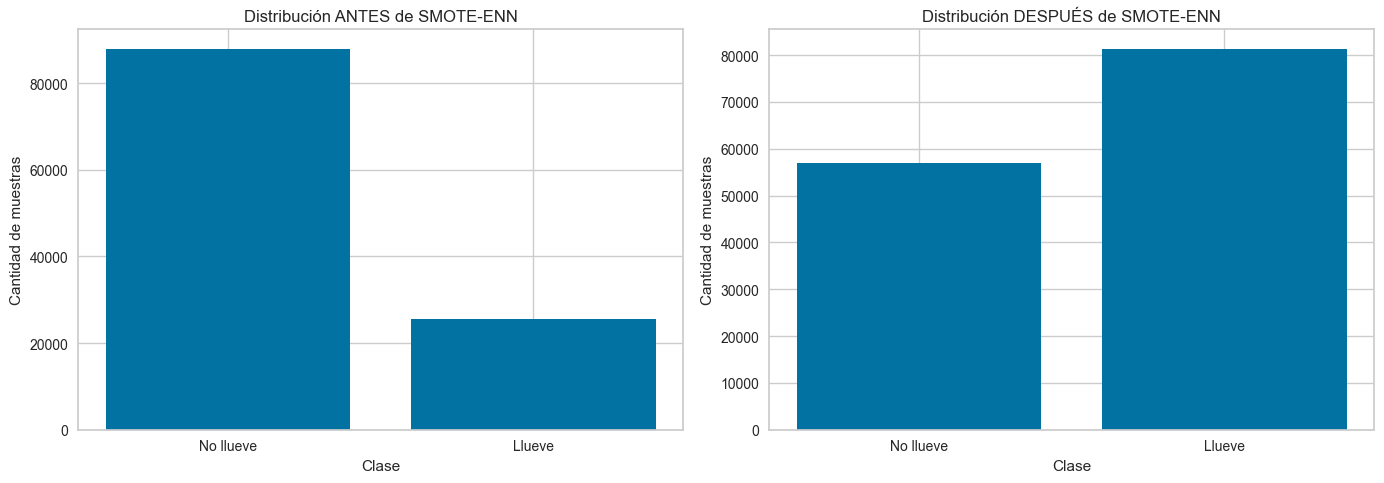

In [56]:
# Separar las variables predictoras (X) de la variable objetivo (y)
x_train = train_df.drop(columns=['RainTomorrow_Yes'])
y_train = train_df['RainTomorrow_Yes']

x_test = test_df.drop(columns=['RainTomorrow_Yes'])
y_test = test_df['RainTomorrow_Yes']

# Reporte rápido
print("Tamaño entrenamiento:", x_train.shape)
print("Tamaño prueba:", x_test.shape)
print("Distribución en y_train:")
print(y_train.value_counts(normalize=True))
print("\nDistribución en y_test:")
print(y_test.value_counts(normalize=True))

# Verificar distribución antes de SMOTE-ENN
print("Distribución ANTES de SMOTE-ENN:")
print(f"Clase 0 (No llueve): {(y_train == 0).sum()} ({(y_train == 0).sum() / len(y_train) * 100:.2f}%)")
print(f"Clase 1 (Llueve): {(y_train == 1).sum()} ({(y_train == 1).sum() / len(y_train) * 100:.2f}%)")
print(f"Total: {len(y_train)}")

# Aplicar SMOTE-ENN solo al conjunto de entrenamiento
smote_enn = SMOTEENN(random_state=0)
x_train_resampled_enn, y_train_resampled_enn = smote_enn.fit_resample(x_train, y_train)

# Verificar distribución después de SMOTE-ENN
print("\nDistribución DESPUÉS de SMOTE-ENN:")
print(f"Clase 0 (No llueve): {(y_train_resampled_enn == 0).sum()} ({(y_train_resampled_enn == 0).sum() / len(y_train_resampled_enn) * 100:.2f}%)")
print(f"Clase 1 (Llueve): {(y_train_resampled_enn == 1).sum()} ({(y_train_resampled_enn == 1).sum() / len(y_train_resampled_enn) * 100:.2f}%)")
print(f"Total: {len(y_train_resampled_enn)}")

# Visualizar la distribución
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Antes de SMOTE-ENN
axes[0].bar(['No llueve', 'Llueve'], [((y_train == 0).sum()), ((y_train == 1).sum())])
axes[0].set_title('Distribución ANTES de SMOTE-ENN')
axes[0].set_ylabel('Cantidad de muestras')
axes[0].set_xlabel('Clase')

# Después de SMOTE-ENN
axes[1].bar(['No llueve', 'Llueve'], [((y_train_resampled_enn == 0).sum()), ((y_train_resampled_enn == 1).sum())])
axes[1].set_title('Distribución DESPUÉS de SMOTE-ENN')
axes[1].set_ylabel('Cantidad de muestras')
axes[1].set_xlabel('Clase')

plt.tight_layout()
plt.show()

Distribución DESPUÉS de SMOTE-Tomek:
Clase 0 (No llueve): 87731 (50.00%)
Clase 1 (Llueve): 87731 (50.00%)
Total: 175462


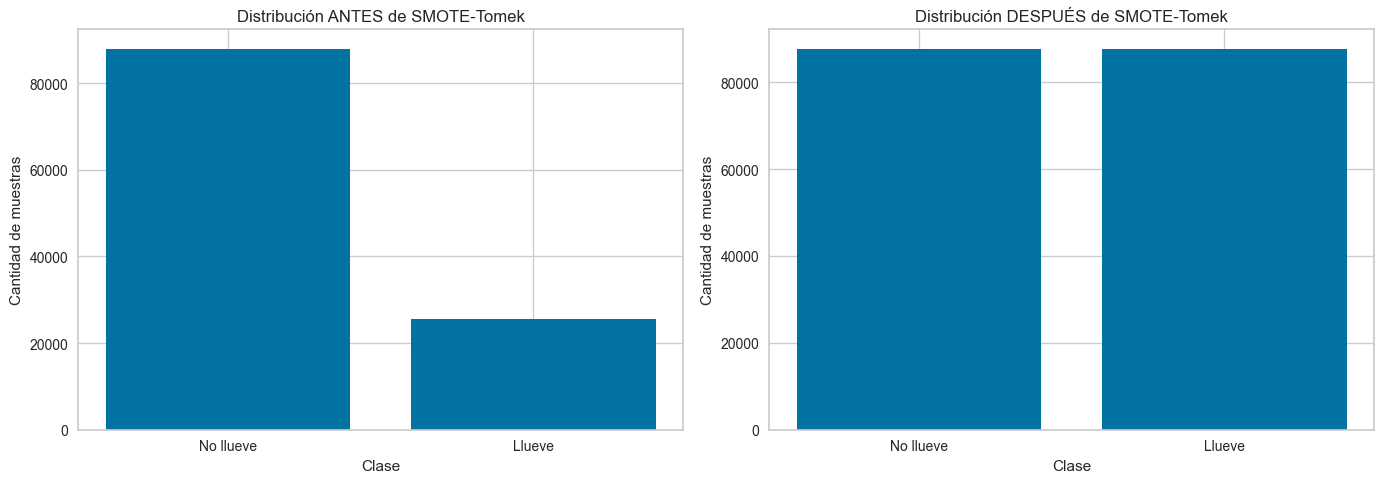

In [57]:
# Aplicar SMOTE-Tomek solo al conjunto de entrenamiento
smote_tomek = SMOTETomek(random_state=0)
x_train_resampled_tomek, y_train_resampled_tomek = smote_tomek.fit_resample(x_train, y_train)

# Verificar distribución después de SMOTE-Tomek
print("Distribución DESPUÉS de SMOTE-Tomek:")
print(f"Clase 0 (No llueve): {(y_train_resampled_tomek == 0).sum()} ({(y_train_resampled_tomek == 0).sum() / len(y_train_resampled_tomek) * 100:.2f}%)")
print(f"Clase 1 (Llueve): {(y_train_resampled_tomek == 1).sum()} ({(y_train_resampled_tomek == 1).sum() / len(y_train_resampled_tomek) * 100:.2f}%)")
print(f"Total: {len(y_train_resampled_tomek)}")

# Visualizar la distribución
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Antes de SMOTE-Tomek
axes[0].bar(['No llueve', 'Llueve'], [((y_train == 0).sum()), ((y_train == 1).sum())])
axes[0].set_title('Distribución ANTES de SMOTE-Tomek')
axes[0].set_ylabel('Cantidad de muestras')
axes[0].set_xlabel('Clase')

# Después de SMOTE-Tomek
axes[1].bar(['No llueve', 'Llueve'], [((y_train_resampled_tomek == 0).sum()), ((y_train_resampled_tomek == 1).sum())])
axes[1].set_title('Distribución DESPUÉS de SMOTE-Tomek')
axes[1].set_ylabel('Cantidad de muestras')
axes[1].set_xlabel('Clase')

plt.tight_layout()
plt.show()

# 3. Regresión logística

In [58]:
# x_train, y_train
# x_train_resampled_enn, y_train_resampled_enn
# x_train_resampled_tomek, y_train_resampled_tomek

model_l2 = LogisticRegression()
model_l2.fit(x_train, y_train)

y_pred_l2 = model_l2.predict(x_test)

y_pred_l2 = model_l2.predict(x_test)
y_proba_l2 = model_l2.predict_proba(x_test)[:, 1]
f1_l2 = f1_score(y_test, y_pred_l2)

print(f"F1-score (L2 default): {f1_l2:.2f}")

F1-score (L2 default): 0.58


In [59]:
# x_train, y_train
# x_train_resampled_enn, y_train_resampled_enn
# x_train_resampled_tomek, y_train_resampled_tomek

model_l2 = LogisticRegression()
model_l2.fit(x_train, y_train)

y_pred_l2 = model_l2.predict(x_test)
f1_l2 = f1_score(y_test, y_pred_l2)

model_enn = LogisticRegression()
model_enn.fit(x_train_resampled_enn, y_train_resampled_enn)

y_pred_enn = model_enn.predict(x_test)
f1_enn = f1_score(y_test, y_pred_enn)

model_tomek = LogisticRegression()
model_tomek.fit(x_train_resampled_tomek, y_train_resampled_tomek)

y_pred_tomek = model_tomek.predict(x_test)
f1_tomek = f1_score(y_test, y_pred_tomek)

print(f"F1-score (L2 default): {f1_l2:.2f}")
print(f"F1-score (SMOTE-ENN): {f1_enn:.2f}")
print(f"F1-score (SMOTE-Tomek): {f1_tomek:.2f}")


F1-score (L2 default): 0.58
F1-score (SMOTE-ENN): 0.59
F1-score (SMOTE-Tomek): 0.61


Vemos que con un balanceo hecho a partir de SMOTE-Tomek, no sólo el valor de F1-score mejora, si no que las clases quedan cada una con $50\%$ del total de los datos. Con esto, sumado al hecho de que Tomek nos deja un dataset más grande y más fiel al original, se decidió continuar trabajando con este.

In [60]:
y_proba = model_tomek.predict_proba(x_test)[:, 1]

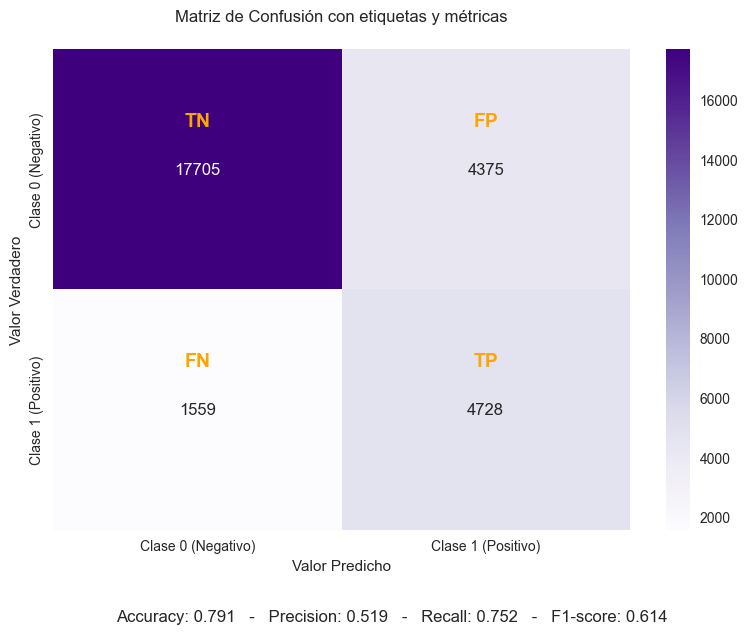

In [61]:
# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred_tomek)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred_tomek)
precision = precision_score(y_test, y_pred_tomek)
recall = recall_score(y_test, y_pred_tomek)
f1 = f1_score(y_test, y_pred_tomek)

# Crear la figura
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Clase 0 (Negativo)', 'Clase 1 (Positivo)'],
            yticklabels=['Clase 0 (Negativo)', 'Clase 1 (Positivo)'])

plt.ylabel('Valor Verdadero')
plt.xlabel('Valor Predicho')
plt.title('Matriz de Confusión con etiquetas y métricas', pad=20)

# Anotaciones TN, FP, FN, TP (coordenadas ajustadas al centro de cada celda)
plt.text(0.5, 0.3, 'TN', ha='center', va='center', color='orange', fontsize=14, fontweight='bold')
plt.text(1.5, 0.3, 'FP', ha='center', va='center', color='orange', fontsize=14, fontweight='bold')
plt.text(0.5, 1.3, 'FN', ha='center', va='center', color='orange', fontsize=14, fontweight='bold')
plt.text(1.5, 1.3, 'TP', ha='center', va='center', color='orange', fontsize=14, fontweight='bold')

# Mostrar métricas debajo del gráfico
plt.figtext(0.5, -0.05,
            f'Accuracy: {accuracy:.3f}   -   Precision: {precision:.3f}   -   Recall: {recall:.3f}   -   F1-score: {f1:.3f}',
            wrap=True, horizontalalignment='center', fontsize=12)

plt.tight_layout()
plt.show()

- Falsos Negativos (FN = 1,559): Son los días en que el modelo predijo 'No lloverá', pero sí llovió. En el contexto de predicción de lluvia , este es el error más costoso.

- Falsos Positivos (FP = 4,375): Son los días en que el modelo predijo 'Lloverá', pero no llovió. Este error es menos costoso que el FN , pero la alta cantidad de 4,367 FPs contribuye a la baja Precision (Precision=0.520).

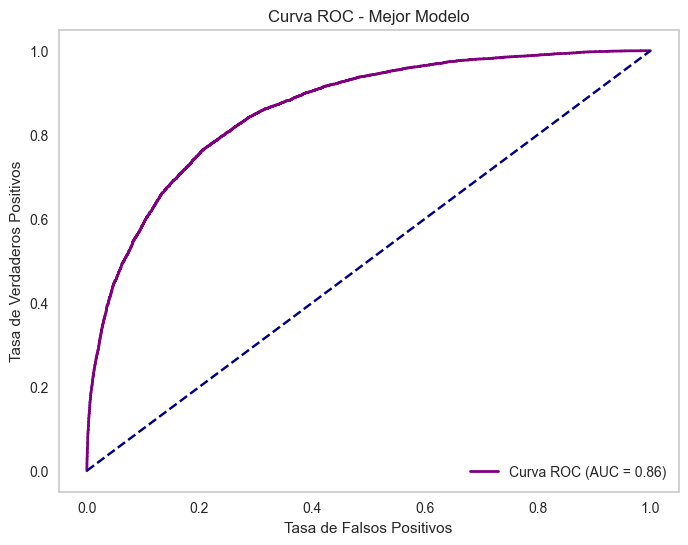


Óptimo umbral (maximizando F1-score): 0.6146
F1-score con umbral óptimo: 0.6209
F1-score con umbral 0.5: 0.6144

Métricas con umbral óptimo:
Accuracy: 0.8210
Precision: 0.5850
Recall: 0.6615
F1-score: 0.6209


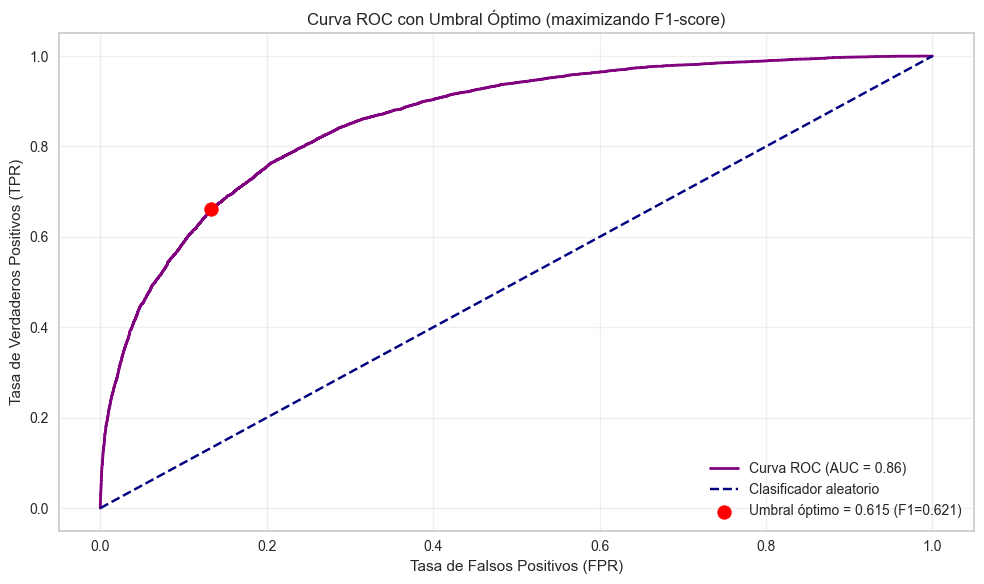

In [62]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})', color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Mejor Modelo')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Encontrar el umbral óptimo maximizando F1-score
f1_scores = []
for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))

# Obtener el índice del mejor F1-score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
best_f1 = f1_scores[optimal_idx]

print(f"\nÓptimo umbral (maximizando F1-score): {optimal_threshold:.4f}")
print(f"F1-score con umbral óptimo: {best_f1:.4f}")
print(f"F1-score con umbral 0.5: {f1_score(y_test, y_pred_tomek):.4f}")

# Aplicar el umbral óptimo
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

# Calcular métricas con el umbral óptimo
print("\nMétricas con umbral óptimo:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimal):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimal):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_optimal):.4f}")

# Visualizar la curva ROC con el punto óptimo
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})', color='purple', lw=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Clasificador aleatorio')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, zorder=5,
            label=f'Umbral óptimo = {optimal_threshold:.3f} (F1={best_f1:.3f})')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC con Umbral Óptimo (maximizando F1-score)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

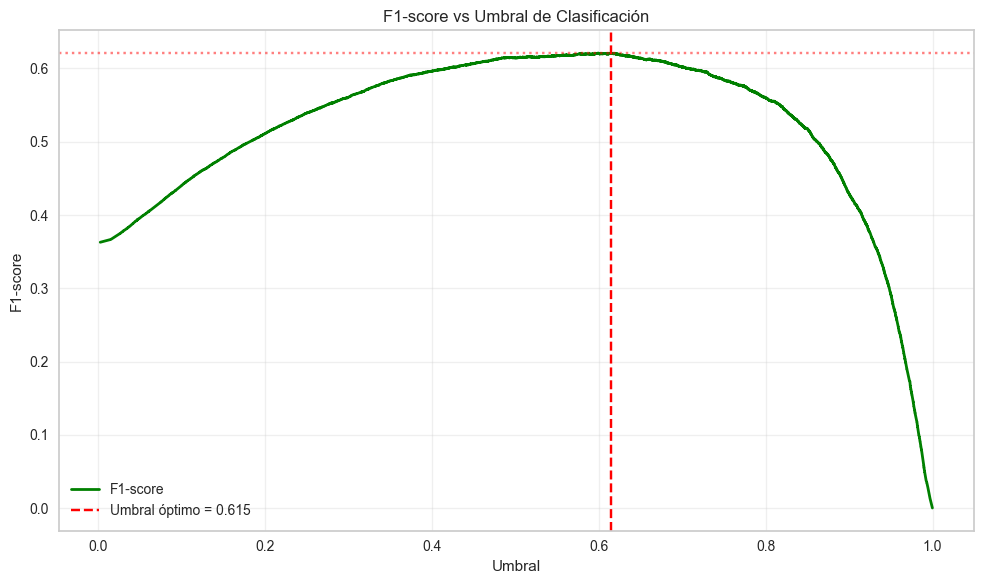


COMPARACIÓN: Umbral 0.5 vs Umbral Óptimo

Umbral = 0.5:
  Accuracy:  0.7908
  Precision: 0.5194
  Recall:    0.7520
  F1-score:  0.6144

Umbral = 0.6146 (óptimo):
  Accuracy:  0.8210
  Precision: 0.5850
  Recall:    0.6615
  F1-score:  0.6209

Mejora con umbral óptimo:
  ΔAccuracy:  +0.0302
  ΔPrecision: +0.0656
  ΔRecall:    -0.0905
  ΔF1-score:  +0.0065


In [63]:
# Visualizar cómo varía F1-score con diferentes umbrales
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score', color='green', lw=2)
plt.axvline(optimal_threshold, color='red', linestyle='--',
            label=f'Umbral óptimo = {optimal_threshold:.3f}')
plt.axhline(best_f1, color='red', linestyle=':', alpha=0.5)
plt.xlabel('Umbral')
plt.ylabel('F1-score')
plt.title('F1-score vs Umbral de Clasificación')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Comparar métricas con umbral 0.5 vs óptimo
print("\n" + "="*60)
print("COMPARACIÓN: Umbral 0.5 vs Umbral Óptimo")
print("="*60)

# Umbral 0.5
print("\nUmbral = 0.5:")
y_pred_05 = (y_proba >= 0.5).astype(int)
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_05):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_05):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_05):.4f}")
print(f"  F1-score:  {f1_score(y_test, y_pred_05):.4f}")

# Umbral óptimo
print(f"\nUmbral = {optimal_threshold:.4f} (óptimo):")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_optimal):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_optimal):.4f}")
print(f"  F1-score:  {f1_score(y_test, y_pred_optimal):.4f}")

# Mostrar diferencias
print("\nMejora con umbral óptimo:")
print(f"  ΔAccuracy:  {accuracy_score(y_test, y_pred_optimal) - accuracy_score(y_test, y_pred_05):+.4f}")
print(f"  ΔPrecision: {precision_score(y_test, y_pred_optimal) - precision_score(y_test, y_pred_05):+.4f}")
print(f"  ΔRecall:    {recall_score(y_test, y_pred_optimal) - recall_score(y_test, y_pred_05):+.4f}")
print(f"  ΔF1-score:  {f1_score(y_test, y_pred_optimal) - f1_score(y_test, y_pred_05):+.4f}")

La Curva ROC muestra un AUC de $0.86$, lo que indica que el modelo es capaz de distinguir bien entre las clases. Observando el gráfico F1-score vs. Umbral, se determinó que el valor que maximiza el F1-score es $Umbral = 0.6146$, logrando un $F1-score = 0.6209$. Al cambiar el umbral de $0.5$ a $0.6146$, el F1-score mejoró en $+0.0065$. La mejora en F1-score se debe a un aumento de Precision (de $0.5194$ a $0.5850$) a expensas de una pérdida de Recall (de $0.7535$ a $0.6929$). En resumen, el umbral $0.6146$ es mejor si el objetivo es maximizar el balance general.

El AUC de $0.86$ y el F1-score de $0.6146$ indican que la Regresión Logística ha conseguido un buen fitting inicial. Sin embargo, dada la alta cantidad de Falsos Positivos ($FP=4,375$) y la todavía moderada Precision ($Precision=0.5850$ con umbral óptimo), es evidente que existe margen de mejora.

# 4. Modelo base

In [64]:
x_train = x_train_resampled_tomek.copy()
y_train = y_train_resampled_tomek.copy()

Se implementa el modelo DummyClassifier

In [65]:
# Modelo dummy base
model_dummy_base = DummyClassifier(strategy='stratified', random_state=0)
model_dummy_base.fit(x_train, y_train)

# Predicciones
y_pred_dummy_base = model_dummy_base.predict(x_test)
y_proba_dummy_base = model_dummy_base.predict_proba(x_test)[:, 1]

# Métricas
accuracy = accuracy_score(y_test, y_pred_dummy_base)
roc_auc_dummy = roc_auc_score(y_test, y_proba_dummy_base)
f1_dummy = f1_score(y_test, y_pred_dummy_base)

# Reporte
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_dummy_base))
print(f"ROC AUC: {roc_auc_dummy:.2f}")
print(f"F1-score: {f1_dummy:.2f}")


Reporte de Clasificación:
              precision    recall  f1-score   support

       False       0.77      0.49      0.60     22080
        True       0.22      0.49      0.30      6287

    accuracy                           0.49     28367
   macro avg       0.50      0.49      0.45     28367
weighted avg       0.65      0.49      0.54     28367

ROC AUC: 0.49
F1-score: 0.30


## Matriz de confusión

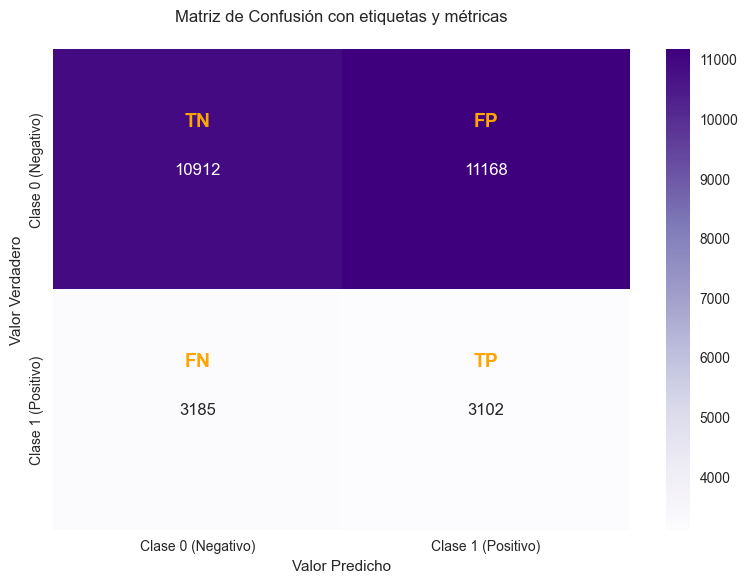

In [66]:
# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred_dummy_base)

# Crear la figura
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Clase 0 (Negativo)', 'Clase 1 (Positivo)'],
            yticklabels=['Clase 0 (Negativo)', 'Clase 1 (Positivo)'])

plt.ylabel('Valor Verdadero')
plt.xlabel('Valor Predicho')
plt.title('Matriz de Confusión con etiquetas y métricas', pad=20)

# Anotaciones TN, FP, FN, TP (coordenadas ajustadas al centro de cada celda)
plt.text(0.5, 0.3, 'TN', ha='center', va='center', color='orange', fontsize=14, fontweight='bold')
plt.text(1.5, 0.3, 'FP', ha='center', va='center', color='orange', fontsize=14, fontweight='bold')
plt.text(0.5, 1.3, 'FN', ha='center', va='center', color='orange', fontsize=14, fontweight='bold')
plt.text(1.5, 1.3, 'TP', ha='center', va='center', color='orange', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [67]:
# Análisis básico
tn, fp, fn, tp = cm.ravel()
print(f"Falsos Positivos: {fp} - El modelo predijo '1' cuando era '0'")
print(f"Falsos Negativos: {fn} - El modelo predijo '0' cuando era '1'")

Falsos Positivos: 11168 - El modelo predijo '1' cuando era '0'
Falsos Negativos: 3185 - El modelo predijo '0' cuando era '1'


- Falsos Negativos (FN = 3.185): Son los días en que el modelo predijo 'No lloverá', pero sí llovió. En el contexto de predicción de lluvia, este es el error más costoso.

- Falsos Positivos (FP = 11.168): Son los días en que el modelo predijo 'Lloverá', pero no llovió. Este error es menos costoso que el FN, pero la alta cantidad de FPs contribuye a la baja Precision (Precision=0.22).

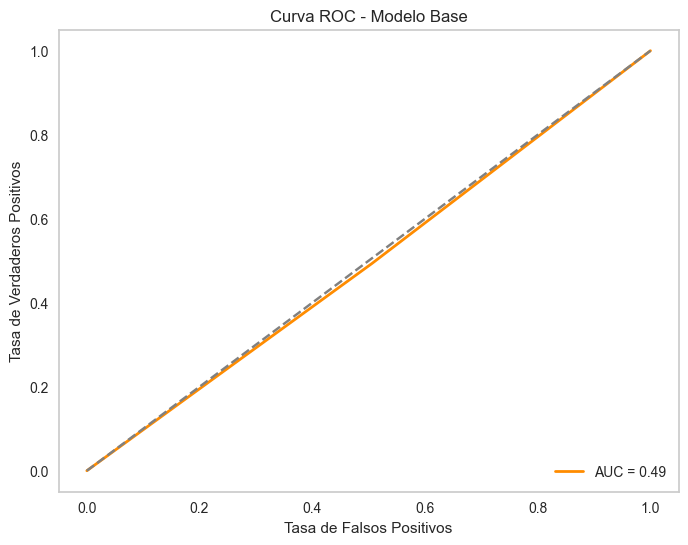

In [68]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_dummy_base)
roc_auc = roc_auc_score(y_test, y_proba_dummy_base)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Modelo Base')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [69]:
# Mejor umbral (máximo F1)
thresholds = np.arange(0, 1.01, 0.01)
f1_scores = [f1_score(y_test, (y_proba_dummy_base >= t).astype(int)) for t in thresholds]

best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Mejor umbral por F1-score: {best_thresh:.2f} (F1 = {best_f1:.2f})")

Mejor umbral por F1-score: 0.00 (F1 = 0.36)


In [70]:
# Comparación de modelos
def evaluar_modelo(nombre, y_test, y_pred, y_proba):
    """
    Función para evaluar un modelo.
    :param nombre: Nombre del modelo.
    :param y_true: Etiquetas verdaderas.
    :param y_pred: Etiquetas predichas.
    :param y_proba: Probabilidades de pertenencia a la clase positiva.
    """
    print(f"\n=== {nombre} ===")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC  :  {roc_auc_score(y_test, y_proba):.2f}")

evaluar_modelo("Modelo Base", y_test, y_pred_dummy_base, y_proba_dummy_base)
evaluar_modelo("Regresión Logística", y_test, y_pred_tomek, y_proba)


=== Modelo Base ===
              precision    recall  f1-score   support

       False       0.77      0.49      0.60     22080
        True       0.22      0.49      0.30      6287

    accuracy                           0.49     28367
   macro avg       0.50      0.49      0.45     28367
weighted avg       0.65      0.49      0.54     28367

ROC AUC  :  0.49

=== Regresión Logística ===
              precision    recall  f1-score   support

       False       0.92      0.80      0.86     22080
        True       0.52      0.75      0.61      6287

    accuracy                           0.79     28367
   macro avg       0.72      0.78      0.74     28367
weighted avg       0.83      0.79      0.80     28367

ROC AUC  :  0.86


Como se puede visualizar arriba, el modelo base obtiene un accuracy del $49$% y un ROC AUC de $0.49$, lo que se traduce en que clasfica de forma aleatoria. 

Por el contrario, el modelo de regresión logística aumenta el accuracy a $79$% y alcanza un ROC AUC de $0.86$, indicando que cuenta con una capacidad significativa para discriminar entre las clases.

Esto confirma que el modelo de regresión logística es mucho más efictivo que el modelo base para identificar las distintas clases.

# 5. Optimización de hiperparámetros

## Grid search / Random forest / Optuna

In [ ]:
scores = ["precision", "recall"]

def print_dataframe(filtered_cv_results):
    ### print de los resultados de cross validation
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()


def refit_strategy(cv_results):
    """Define la estrategia para seleccionar el mejor estimador.

    La estrategia definida aquí es filtrar todos los resultados por debajo de un umbral
    de precisión de 0.7, clasificar los restantes por recall y
    mantener todos los modelos dentro de una desviación estándar del mejor por recall.
    Una vez que estos modelos son seleccionados, podemos escoger el modelo más rápido para predecir.

    Parámetros
    ----------
    cv_results : dict of numpy (masked) ndarrays
        Resultados de la validación cruzada (CV) tal como los devuelve `GridSearchCV`.

    Devuelve
    -------
    best_index : int
        El índice del mejor estimador tal como aparece en `cv_results`.
    """
    # Imprimir la información sobre grid-search para los diferentes scores
    precision_threshold = 0.7

    cv_results_ = pd.DataFrame(cv_results)
    print("Todos los resultados de gridSearch:")
    print_dataframe(cv_results_)

    # Filtrar todos los resultados por debajo del umbral
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Modelos con una precisión mayor que {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
            "De los modelos de alta precisión seleccionados previamente, mantenemos todos los\n"
            "modelos dentro de una desviación estándar del modelo de recall más alto:"
    )
    print_dataframe(high_recall_cv_results)

    # De los mejores candidatos, seleccionamos el modelo más rápido para predecir
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nEl modelo final seleccionado es el más rápido para predecir de entre el subconjunto\n"
        "de mejores modelos seleccionados previamente con base en la precisión y el recall.\n"
        "Su tiempo de scoring es:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index


La optimización de los siguientes hiperparámetros se realiza con el fin de mitigar el desbalance de clases (class_weight), controlar la complejidad del modelo (C) y asegurar que el algoritmo de optimización converja de manera eficiente (solver y max_iter). Al probar un rango logarítmico para C, buscamos el punto óptimo entre un modelo simple (alta regularización) y un modelo complejo (baja regularización).

In [72]:
# Grid

tuned_parameters = [
    {"class_weight": [None, 'balanced'], "C": [0.1, 1, 10, 100], "solver": ['newton-cg'], "max_iter": [200, 500]}
]

grid_search = GridSearchCV(
    LogisticRegression(), tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(x_train, y_train)



All grid-search results:
precision: 0.800 (±0.005), recall: 0.784 (±0.021), for {'C': 0.1, 'class_weight': None, 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.800 (±0.005), recall: 0.784 (±0.021), for {'C': 0.1, 'class_weight': None, 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.800 (±0.005), recall: 0.784 (±0.021), for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.800 (±0.005), recall: 0.784 (±0.021), for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.800 (±0.005), recall: 0.785 (±0.021), for {'C': 1, 'class_weight': None, 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.800 (±0.005), recall: 0.785 (±0.021), for {'C': 1, 'class_weight': None, 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.800 (±0.005), recall: 0.785 (±0.021), for {'C': 1, 'class_weight': 'balanced', 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.800 (±0.005), recall: 0.785 (±0.021), for {'C': 1, 'cl

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'C': [0.1, 1, 10, 100],
                          'class_weight': [None, 'balanced'],
                          'max_iter': [200, 500], 'solver': ['newton-cg']}],
             refit=<function refit_strategy at 0x000002A500DC03A0>,
             scoring=['precision', 'recall'])

In [73]:
grid_search.best_params_

{'C': 10, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'newton-cg'}

In [74]:
y_pred_grid = grid_search.predict(x_test)
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

       False       0.92      0.80      0.86     22080
        True       0.52      0.75      0.61      6287

    accuracy                           0.79     28367
   macro avg       0.72      0.78      0.74     28367
weighted avg       0.83      0.79      0.80     28367



In [75]:
param_dist = {
    'C': loguniform(1e-3, 1e3),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 250, 500],
    'class_weight': ['balanced'],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

random_search = RandomizedSearchCV(
    LogisticRegression(),
    param_distributions=param_dist,
    n_iter=10,
    cv=cv,
    scoring='f1',
    n_jobs=1,
    random_state=42,
    verbose=1
)

random_search.fit(x_train, y_train)

print("Mejor resultado - RandomizedSearch:")
print(random_search.best_params_)
print(f"F1 score: {random_search.best_score_:.2f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejor resultado - RandomizedSearch:
{'C': 659.871107205407, 'class_weight': 'balanced', 'max_iter': 250, 'penalty': 'l2', 'solver': 'saga'}
F1 score: 0.79


In [76]:
random_search.fit(x_train, y_train)
best_random_params = random_search.best_params_
best_random_model = LogisticRegression(**best_random_params, random_state=0)
best_random_model.fit(x_train, y_train)

# Evaluar en test set
y_pred_random = best_random_model.predict(x_test)
print(classification_report(y_test, y_pred_random))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

       False       0.92      0.80      0.86     22080
        True       0.52      0.75      0.61      6287

    accuracy                           0.79     28367
   macro avg       0.72      0.78      0.74     28367
weighted avg       0.83      0.79      0.80     28367



In [77]:
def objective(trial):
    C = trial.suggest_float('C', 0.1, 100, log=True)
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear'])
    max_iter = trial.suggest_int('max_iter', 200, 1000)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    params = {
        'C': C,
        'solver': solver,
        'max_iter': max_iter,
        'class_weight': class_weight
    }

    # Entrenar y evaluar modelo
    model = LogisticRegression(**params, random_state=0)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    f1 = f1_score(y_test, y_pred)
    return f1

In [78]:
study = optuna.create_study(direction='maximize')  # Maximizar F1 (en lugar de minimizar MSE)
study.optimize(objective, n_trials=10)
best_optuna_params = study.best_params
best_optuna_model = LogisticRegression(**best_optuna_params, random_state=0)
best_optuna_model.fit(x_train, y_train)

[I 2025-11-07 12:42:45,031] A new study created in memory with name: no-name-27ff263b-355b-47e3-b649-24e033d9f29b
[I 2025-11-07 12:42:50,100] Trial 0 finished with value: 0.6144758195391107 and parameters: {'C': 0.11146955371979561, 'solver': 'liblinear', 'max_iter': 329, 'class_weight': None}. Best is trial 0 with value: 0.6144758195391107.
[I 2025-11-07 12:42:54,747] Trial 1 finished with value: 0.6143858737990132 and parameters: {'C': 0.12233633123637935, 'solver': 'liblinear', 'max_iter': 205, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6144758195391107.
[I 2025-11-07 12:42:58,078] Trial 2 finished with value: 0.6143052036640031 and parameters: {'C': 1.1542337885785776, 'solver': 'newton-cg', 'max_iter': 472, 'class_weight': None}. Best is trial 0 with value: 0.6144758195391107.
[I 2025-11-07 12:43:02,033] Trial 3 finished with value: 0.6142949967511371 and parameters: {'C': 9.625491549573917, 'solver': 'newton-cg', 'max_iter': 966, 'class_weight': None}. Best is tri

LogisticRegression(C=37.1039375771061, max_iter=854, random_state=0)

In [79]:
# Evaluar en test set
y_pred_optuna = best_optuna_model.predict(x_test)
print(classification_report(y_test, y_pred_optuna))

              precision    recall  f1-score   support

       False       0.92      0.80      0.86     22080
        True       0.52      0.75      0.61      6287

    accuracy                           0.79     28367
   macro avg       0.72      0.78      0.74     28367
weighted avg       0.83      0.79      0.80     28367



In [80]:
best_optuna_params

{'C': 37.1039375771061,
 'solver': 'lbfgs',
 'max_iter': 854,
 'class_weight': None}

In [81]:
grid_f1 = f1_score(y_test, grid_search.predict(x_test))
random_f1 = f1_score(y_test, y_pred_random)
optuna_f1 = f1_score(y_test, y_pred_optuna)

print("Grid Search F1:", grid_f1)
print("Random Search F1:", random_f1)
print("Optuna F1:", optuna_f1)


Grid Search F1: 0.6143451143451143
Random Search F1: 0.6143451143451143
Optuna F1: 0.6145345813832553


Lo que se puede decir de estos resultados es que, los tres métodos ofrecen un rendimiento casi idéntico en términos de la métrica F1, siendo esta métrica de alrededor del 61.4%.

# 6. Explicabilidad - SHAP

In [82]:
feature_names=x_test.columns.values
feature_names

array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'WindGustDir_sin',
       'WindGustDir_cos', 'WindDir9am_sin', 'WindDir9am_cos',
       'WindDir3pm_sin', 'WindDir3pm_cos', 'Region_1', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7',
       'Season_Otoño', 'Season_Primavera', 'Season_Verano',
       'RainToday_Yes'], dtype=object)

In [83]:
# Crea un objeto explainer SHAP
explainer = shap.LinearExplainer(model_tomek, x_train, feature_names=feature_names)
shap_values = explainer.shap_values(x_test)
idx=0

## Interpretabilidad local

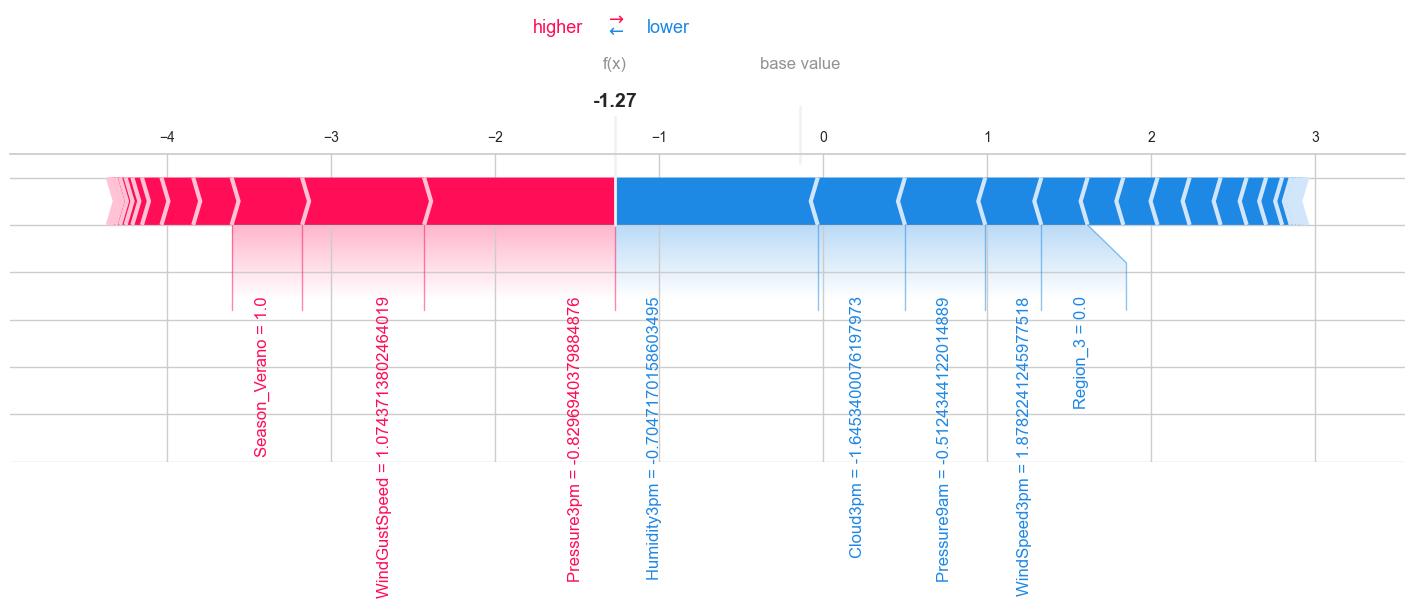

In [84]:
shap.force_plot(explainer.expected_value, shap_values[idx],
                x_test.iloc[idx], feature_names=feature_names,
                matplotlib=True, figsize=(18, 4), text_rotation=90)

Variables que disminuyen la predicción de lluvia (en rojo):
  - Season_Verano: Es el factor más fuerte que reduce la probabilidad de lluvia ($\approx -1.07$).
  - WindGustSpeed (Velocidad de Ráfaga de Viento): Fuerte contribución a "NO LLUVE" ($\approx -1.07$).
  - Pressure3pm (Presión a las 3 pm): También empuja significativamente hacia el tiempo seco ($\approx -0.83$).

Variables que aumentan la predicción de lluvia (en azul):
  - Cloud3pm: Una alta nubosidad en la tarde es un predictor natural de lluvia.
  - Pressure9am: La presión a las 9 am tiene un valor que el modelo asocia con una mayor probabilidad de precipitación.
  - WindSpeed3pm (Velocidad del Viento a las 3 pm): Este es el factor que más empuja a favor de la lluvia ($\approx +1.88$).
  - Region_3: Este factor contribuye fuertemente a la probabilidad de lluvia ($\approx +1.88$).

In [85]:
explanation = shap.Explanation(values=shap_values[idx],
                                base_values=explainer.expected_value,
                                feature_names=feature_names)

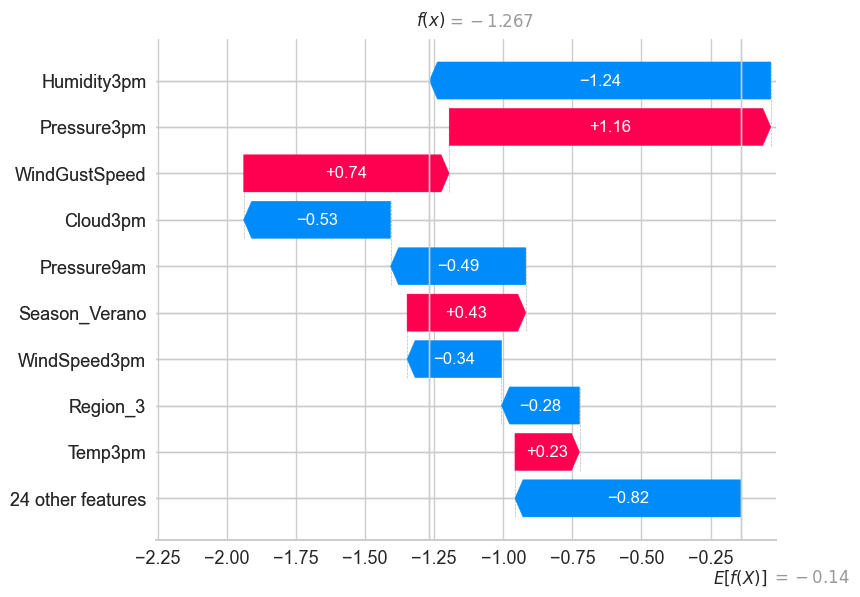

In [86]:
shap.plots.waterfall(explanation)

Variables que aumentan la predicción de lluvia:
  - Pressure3pm ($\mathbf{+1.16}$): Esta es la característica más fuerte que intenta contrarrestar la tendencia y empuja hacia "LLUVE".
  - WindGustSpeed ($\mathbf{+0.74}$): La velocidad de ráfaga de viento también es un fuerte impulsor hacia la predicción de lluvia.
  - Season_Verano ($\mathbf{+0.43}$): Curiosamente, estar en verano contribuye a una mayor probabilidad de lluvia en este día (podría ser una interacción o que el modelo interprete el valor específico de "Verano" de una manera particular para esta instancia).
  - Temp3pm ($\mathbf{+0.23}$): La temperatura en la tarde contribuye ligeramente a la predicción de lluvia.

Valores que disminuyen la predicción de lluvia:
  - Humidity3pm ($\mathbf{-1.24}$): Es el factor más fuerte que impulsa la predicción a "No Llueve".
  - Cloud3pm ($\mathbf{-0.53}$): La nubosidad a las 3 PM también contribuye significativamente a una predicción de tiempo seco.
  - Pressure9am ($\mathbf{-0.49}$): La presión de la mañana empuja la predicción hacia la sequía.
  - WindSpeed3pm ($\mathbf{-0.34}$): La velocidad del viento en la tarde contribuye ligeramente a "No Llueve".
  - Region_3 ($\mathbf{-0.28}$): El valor de la característica de la región también contribuye negativamente.

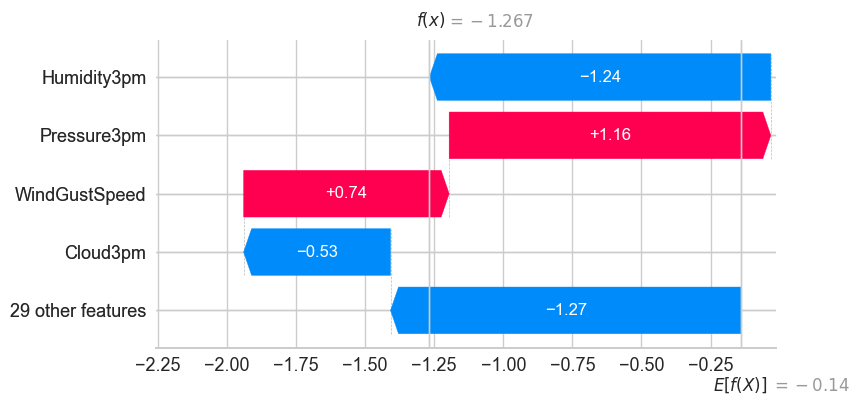

In [87]:
shap.plots.waterfall(explanation, max_display=5)

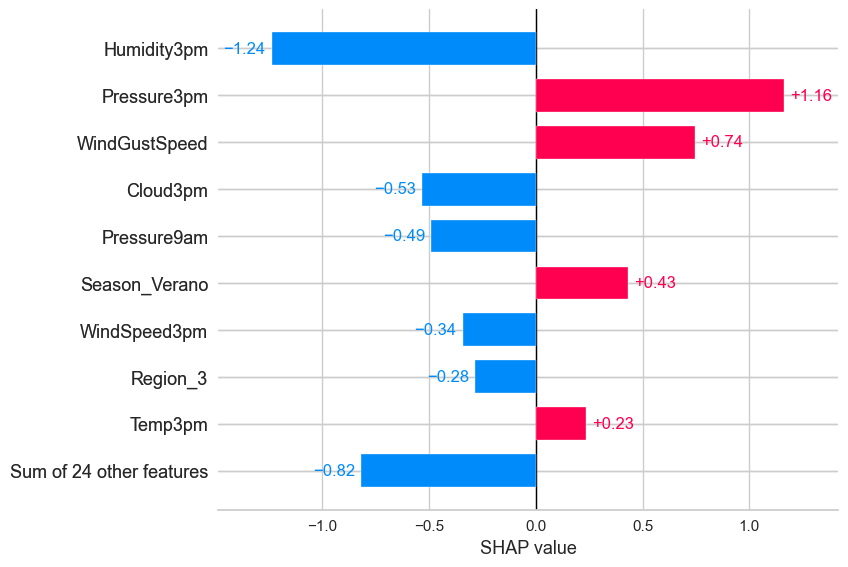

In [88]:
shap.plots.bar(explanation)

En resumen, Humidity3pm es la variable que más afecta negativamente a la predicción de lluvia, sugiriendo que al haber baja humedad a las 3pm, el modelo predice menos lluvia. Y, por el contrario, Pressure3pm es la variable que más afectó positivamente la predicción.

## Interpretabilidad global

In [89]:
explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    feature_names=feature_names
)

In [90]:
print(type(shap_values))
print(np.array(shap_values).shape)
print(np.array(explainer.expected_value).shape)

<class 'numpy.ndarray'>
(28367, 33)
()


In [ ]:
base_values = np.repeat(explainer.expected_value, shap_values.shape[0])

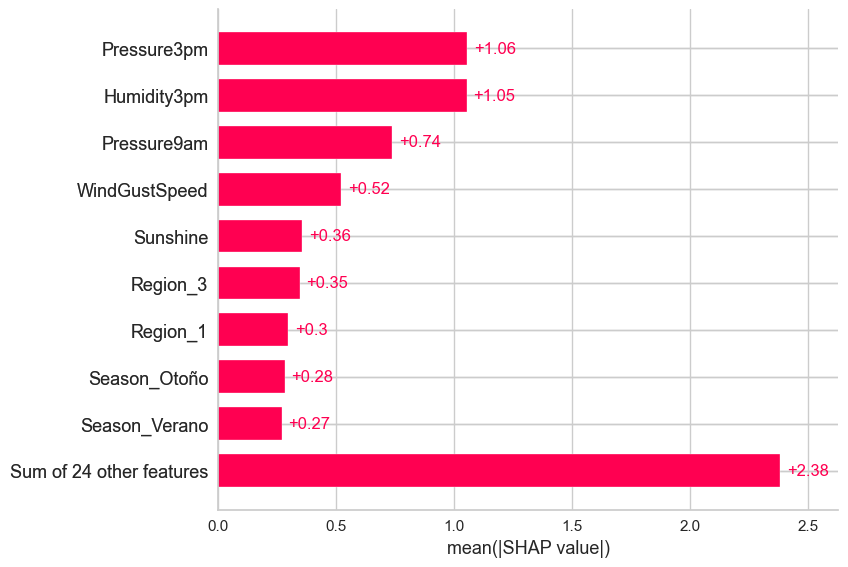

In [92]:
shap.plots.bar(explanation)

Las variables más destacadas en el gráfico de la importancia promedio de cada variable en todas las predicciones del modelo son:
  - Pressure3pm: es la más influyente, indica que la presión en la tarde tiene gran impacto en la predicción.
  - Humidity3pm: también aporta significativamente al resultado, por poco igualando la variable anterior.

In [ ]:
# Valores SHAP: debe ser un array float64
shap_values_fixed = np.array(shap_values, dtype=np.float64)

# Para un explainer lineal que devuelve un solo array, el expected_value suele ser un escalar.
# Si fuera un array de 2 elementos ([0.5, 0.7]), seleccionamos el que corresponde a la Clase 1.
# Por simplicidad, tomaremos el primer elemento o el valor tal cual.
if isinstance(explainer.expected_value, np.ndarray) and explainer.expected_value.ndim > 0:
    base_value_fixed = explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0]
else:
    base_value_fixed = explainer.expected_value

# base_value_fixed debe ser float
base_value_fixed = float(base_value_fixed)

In [ ]:
# Explanation con los valores corregidos
explanation_fixed = shap.Explanation(
    values=shap_values_fixed,
    base_values=base_value_fixed,
    feature_names=feature_names
)

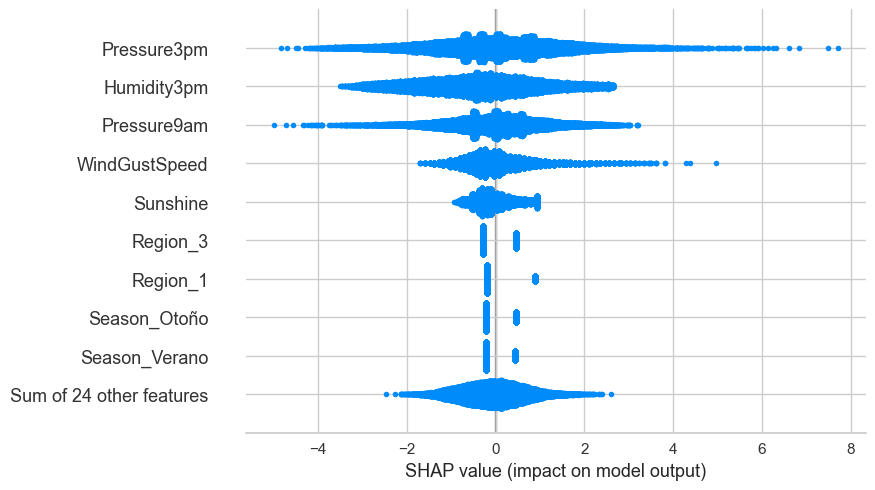

In [99]:
# Graficar el beeswarm
shap.plots.beeswarm(explanation_fixed)

A partir del gráfico anterior, podemos decir que el modelo está principalmente influenciado por la presión, la humedad y el viento.

# 7. AutoML

In [117]:
df_auto_ml = df.copy()

In [118]:
setup(data=df_auto_ml,
      target='RainTomorrow',
      train_size=0.8,
      normalize=True,
      session_id=42)

Interpretación

- Transformaciones realizadas
  - Los datos se expandieron a 71 columnas por el procesamiento
  - Conjunto de entrenamiento: 113.467 filas, 71 columnas
  - Conjunto de prueba: 28.367 filas, 71 columnas

- Features
  - 17 variables numéricas
  - 5 variables categóricas
  - 60.2% de las filas tenían valores faltantes

- Preprocesamiento implementado
  - Imputación numérica: media
  - Imputación categórica: moda
  - Normalización: con z-score (media 0, desviación estándar 1)
  - Balanceo de clases: activado con SMOTE (fix_imbalance=True)

- Validación cruzada
  - Tipo de validación: StratifiedKFold con 10 folds

In [126]:
best_model = compare_models()
print(best_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [127]:
predictions = predict_model(best_model)

In [130]:
y_pred_auto_ml = predictions['prediction_label']
y_test_automl = predictions['RainTomorrow']

f1_automl = f1_score(y_test_automl, y_pred_auto_ml, pos_label='Yes')
print(f"F1-score con AutoML: {f1_automl:.2f}")

F1-score con AutoML: 0.62


Comparación de modelos

1. Desempeño Predictivo y Capacidad Discriminatoria

Los resultados demuestran que los algoritmos basados en técnicas de ensemble y boosting dominan el rendimiento. El modelo Light Gradient Boosting Machine (lightgbm) se estableció como el de mejor desempeño, registrando la $\mathbf{Accuracy}$ más alta ($\mathbf{85.72\%}$) y el $\mathbf{AUC}$ más favorable ($\mathbf{0.8877}$). Esta métrica de AUC valida la sólida capacidad discriminatoria del modelo para diferenciar entre las clases positiva y negativa.

2. Eficiencia Computacional y Escalabilidad

La eficiencia de cálculo fue un factor crítico. El análisis reveló una marcada diferencia en el tiempo de entrenamiento (TT):
  - LightGBM no solo lideró en rendimiento, sino que también demostró una eficiencia superior, completando su entrenamiento en solo $\mathbf{6.16}$ segundos.
  - En contraste, otros modelos de alto rendimiento, como Random Forest, requirieron tiempos de procesamiento significativamente mayores (cercanos a los $\mathbf{94}$ segundos), lo que los hace menos escalables y eficientes en la iteración del proyecto.

3. Conclusión

El modelo Light Gradient Boosting Machine ($\mathbf{lightgbm}$) es formalmente seleccionado como el modelo candidato principal. Su elección se fundamenta 
en su capacidad para ofrecer el rendimiento predictivo más alto (liderando en $\mathbf{Accuracy}$ y $\mathbf{AUC}$) mientras mantiene la máxima eficiencia computacional de su grupo.